In [2]:
%load_ext autoreload
%autoreload 2

In [35]:
import torch
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code
from PFNExperiments.Training.Trainer import visualize_training_results
from PFNExperiments.Training.FlowMatching.CFMLossOTGaussianBase_plus_NLL import CFMLossOTGaussianBase_plus_NLL
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC
from PFNExperiments.LinearRegression.ComparisonModels.Variational_Inference import Variational_Inference
from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.Training.TrainerCurriculumCNF_LearnedBaseDist_plus_nll import TrainerCurriculumCNF_LearnedBaseDist_plus_nll
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig
from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF_LearnedBaseDist import ModelToPosteriorCNF_LearnedBaseDist
from PFNExperiments.LinearRegression.Models.Transformer import MLP
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian2
from PFNExperiments.LinearRegression.Models.Transformer_CNF_DoubleCondition2 import TransformerDecoderConditionalDouble_parallel, MLPConditionalDouble_parallel
from PFNExperiments.LinearRegression.Models.Transformer_CNF_LearnedBaseDistribution import TransformerReturnRepresentations, TransformerCNFConditionalDecoderDouble_parallel_learnedBaseDistribution
from PFNExperiments.Evaluation.Evaluate import Evaluate
import pandas as pd

In [4]:
N = 100
P = 10
BATCH_SIZE = 3
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 67
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE
SAVE_PATH = "Training/FlowMatching/SaveFolderTesting"

#BATCH_SIZE = 128

In [5]:
a = 5.0
b = 2.0
tau = 1.0

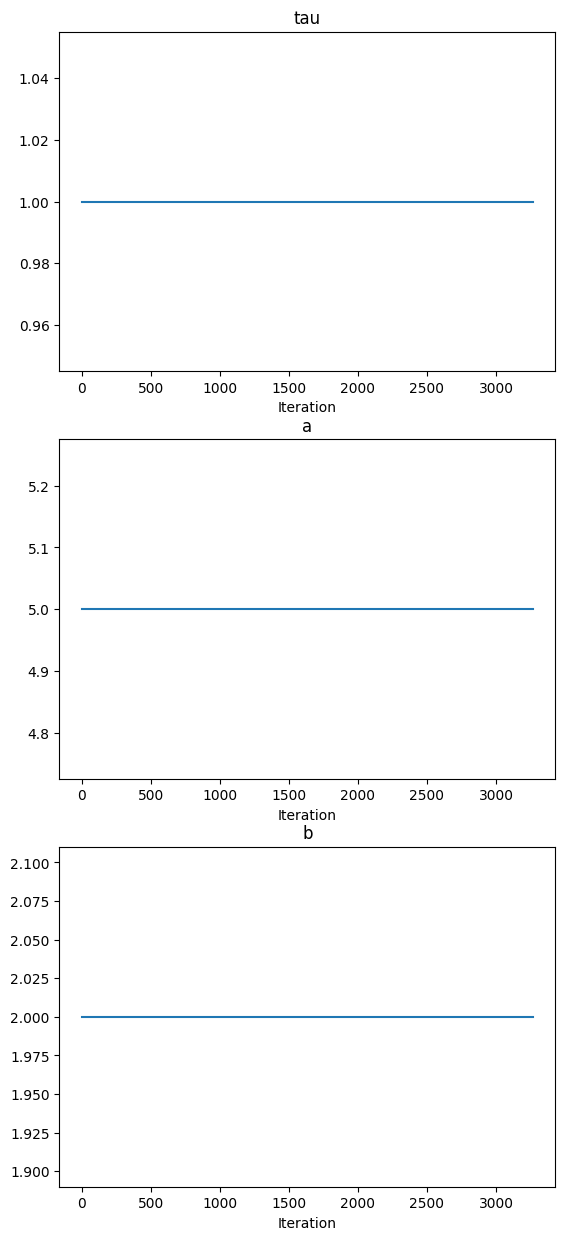

In [6]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list(
    [
    ("tau", curriculum.constant_scheduler(tau)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),

    ]
)
curriculum.plot_all_schedules()

In [7]:
curriculum.get_params(299*N_SAMPLES_PER_EPOCH)

{'tau': 1.0, 'a': 5.0, 'b': 2.0}

In [8]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_lm_program_ig_batched,
    curriculum= curriculum,
    #base_distribution_sampling = GaussianSample,
    #coupling = None
)

In [9]:
"""
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = 5,
    used_batch_samples = 1
)
"""

'\ndata_generator.check_model(\n    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,\n    epochs_to_check = [0, N_EPOCHS-1],\n    p = 5,\n    used_batch_samples = 1\n)\n'

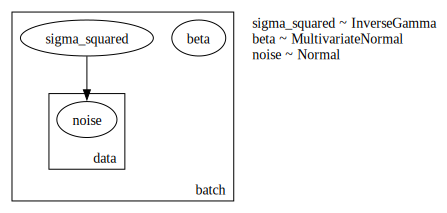

In [10]:
data_generator.render_model()

In [11]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 6600 and 3300 respectively


In [12]:
sample_batch = next(iter(epoch_loader[0][0]))

In [13]:
sample_batch.keys()

dict_keys(['x', 'y', 'sigma_squared', 'beta', 'time', 'base_sample_beta'])

In [14]:
for key in sample_batch.keys():
    print(key, sample_batch[key].shape)

x torch.Size([3, 100, 10])
y torch.Size([3, 100])
sigma_squared torch.Size([3, 1])
beta torch.Size([3, 10])
time torch.Size([3])
base_sample_beta torch.Size([3, 10])


In [15]:
encoder = TransformerReturnRepresentations(
    n_features= P+1,
    seq_len= N,
    d_model= 512,
    n_heads= 8,
    dim_feedforward=512*2,
    dropout_rate = 0.1,
    n_layers=6,
    n_skip_layers_final_heads = 2,
    n_output_units_per_head=[P, P*P, P]
)

#encoder.load_state_dict(torch.load("C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/LinearRegression/Models/TestModels/SavedBaseModel/model.pth", map_location=torch.device('cpu')))
# get the correct class to transform model predictions to posterior samples

c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
# Initialize the pre-trained encoder model


model_posterior = ModelPosteriorFullGaussian2(cov_reg_factor = 1e-3, use_lowrank_normal = False, diag_transform = lambda x: x**2)

nll_loss = model_posterior.negative_log_likelihood
nll_loss_avg = model_posterior.negative_log_likelihood_avg
nll_loss_std = model_posterior.negative_log_likelihood_std
nll_loss_median = model_posterior.negative_log_likelihood_median

mlp_to_process_encoder_output = MLP(
    n_input_units = encoder.d_model,
    n_output_units= 1024,
    n_hidden_units= 1024,
    n_skip_layers= 3,
    dropout_rate = 0.1
)

mlp_to_process_time_conditioning = MLP(
    n_input_units = 1,
    n_output_units = 64,
    n_hidden_units= 64,
    n_skip_layers= 2,
    dropout_rate = 0.1
)
decoder = TransformerDecoderConditionalDouble_parallel(
    n_input_features= P,
    d_model_decoder= 256,
    d_model_encoder= encoder.d_model,
    n_heads= 8,
    d_ff = 256*2,
    dropout= 0.1,
    n_condition_features_a = mlp_to_process_encoder_output.n_output_units,
    n_condition_features_b = mlp_to_process_time_conditioning.n_output_units,
    n_layers= 1,
    use_positional_encoding=False,
    use_self_attention=False,
)
mlp_to_process_decoder_output = MLPConditionalDouble_parallel(
    n_input_units= decoder.d_model_decoder,
    n_output_units = P,
    n_hidden_units = 256, 
    n_skip_layers = 2,
    dropout_rate = 0.1,
    n_condition_features_a = mlp_to_process_encoder_output.n_output_units,
    n_condition_features_b = mlp_to_process_time_conditioning.n_output_units
)
model = TransformerCNFConditionalDecoderDouble_parallel_learnedBaseDistribution(
    encoder = encoder,
    model_posterior = model_posterior,
    mlp_to_process_encoder_output = mlp_to_process_encoder_output,
    mlp_to_process_time_conditioning = mlp_to_process_time_conditioning,
    mlp_to_process_decoder_output = mlp_to_process_decoder_output,
    decoder = decoder,
    freeze_encoder=False,
)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
'{:.2e}'.format(count_parameters(model))

'4.67e+07'

In [19]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [20]:
lr = 1e-4
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [21]:
loss_fun = CFMLossOTGaussianBase_plus_NLL(
    weight_nll = 0.5,
    NLL_Loss_function= nll_loss,
    sigma_min=1e-3,
    return_sub_losses=True
)

In [22]:
scheduler = OneCycleLR(opt,
                       max_lr = 1e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e2)

scheduler = ReduceLROnPlateau(opt)

additional_evals = {
    nll_loss_avg,
    nll_loss_std,
    nll_loss_median
    
}

In [23]:
trainer = TrainerCurriculumCNF_LearnedBaseDist_plus_nll(
    model = model,
    optimizer=opt,
    scheduler = None,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = SAVE_PATH,
    use_same_timestep_per_batch = False,
    using_OTLossGaussianBase = True,
    sub_losses_names = ["loss_FM", "loss_NLL"]
    
)

In [24]:
trainer.save_path

'Training/FlowMatching/SaveFolderTesting/experiment_2024_07_11_15_28_53'

In [25]:
model = trainer.model

In [26]:
model.eval()

TransformerCNFConditionalDecoderDouble_parallel_learnedBaseDistribution(
  (encoder): TransformerReturnRepresentations(
    (mlp1): PositionwiseFeedForward(
      (w_1): Linear(in_features=11, out_features=261, bias=True)
      (w_2): Linear(in_features=261, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (act1): LeakyReLU(negative_slope=0.01)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1024, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
  

In [27]:
full_model = ModelToPosteriorCNF_LearnedBaseDist(
    model = trainer.model,
    sample_name = "beta",
    sample_shape = (P,),
    n_samples=100,
    solve_adjoint = True,
    sample_only_base_dist = True,
    atol=100,
    rtol=100
)

In [28]:
benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_lm_program_ig(**benchmark_params_ppgrogram)

pprogram1_y = return_only_y(pprogram1)
print_code(pprogram1)

params for pprogram: {'tau': 1.0, 'a': 5.0, 'b': 2.0}
        def multivariate_lm_return_dict(x: torch.Tensor, y: torch.Tensor = None) -> dict:
                # Define distributions for the global parameters
                sigma_squared_dist = dist.InverseGamma(a, b)

                beta_cov = torch.eye(x.shape[1]) * (tau ** 2)  # the covariance matrix of the parameters of the linear model

                sigma_squared = pyro.sample("sigma_squared", sigma_squared_dist).squeeze()

                beta_dist = dist.MultivariateNormal(torch.zeros(x.shape[1]), beta_cov)
                beta = pyro.sample("beta", beta_dist)

                # Compute mean using matrix multiplication
                mean = torch.matmul(x, beta)

                with pyro.plate("data", len(x)):
                        y = pyro.sample("obs", pyro.distributions.Normal(mean, sigma_squared), obs=y)


                return {
                        "x": x,
                        "y": y,
                      

In [29]:
test_loader = trainer.testset

In [30]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram1_y, n_warmup=10, n_samples=50)

vi = Variational_Inference(
    pprogram=pprogram1,
    guide = None,
    n_steps = 20,
    n_samples=50,
    lr = 1e-2
)

In [31]:
evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader= test_loader,
    comparison_models= [hmc_sampler, vi],
    n_evaluation_cases=20,
)

In [32]:
r  = evaluation._run_eval_raw_results()

Sampling posterior:   5%|▍         | 1/21 [00:00<00:08,  2.50it/s]

.
.

Sampling posterior:  10%|▉         | 2/21 [00:00<00:05,  3.52it/s]


.


Sampling posterior:  14%|█▍        | 3/21 [00:00<00:04,  4.30it/s]

.


Sampling posterior:  24%|██▍       | 5/21 [00:01<00:03,  4.75it/s]

.


Sampling posterior:  29%|██▊       | 6/21 [00:01<00:03,  4.82it/s]

.
.

Sampling posterior:  33%|███▎      | 7/21 [00:01<00:02,  4.75it/s]


.


Sampling posterior:  43%|████▎     | 9/21 [00:01<00:02,  5.07it/s]

.


Sampling posterior:  48%|████▊     | 10/21 [00:02<00:02,  5.04it/s]

.


Sampling posterior:  52%|█████▏    | 11/21 [00:02<00:02,  4.89it/s]

.


Sampling posterior:  57%|█████▋    | 12/21 [00:02<00:01,  4.93it/s]

.


Sampling posterior:  62%|██████▏   | 13/21 [00:02<00:01,  5.07it/s]

.
.


Sampling posterior:  71%|███████▏  | 15/21 [00:03<00:01,  4.91it/s]

.
.

Sampling posterior:  76%|███████▌  | 16/21 [00:03<00:01,  4.40it/s]


.


Sampling posterior:  81%|████████  | 17/21 [00:03<00:00,  4.72it/s]

.


Sampling posterior:  90%|█████████ | 19/21 [00:04<00:00,  4.82it/s]

.


Sampling posterior:  95%|█████████▌| 20/21 [00:04<00:00,  5.11it/s]

.
.

Sampling posterior: 100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


In [37]:
pd.DataFrame(r["posterior_model_vs_gt"])

<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF_LearnedBaseDist.ModelToPosteriorCNF_LearnedBaseDist object at 0x0000022DA191D5D0>
                                                                                                                                                                                            gt
joint_Wasserstein_distance with metric euclidean                                          21.082245                                                                                           
joint_MMD                                                                                  0.317431                                                                                           
joint_CST_accuracy                                                                            0.785                                                                                           
joint_CST_roc_auc_score                                                                    0.783333                                                                                           
gt_parameter_Perplextiy                                                        [-782.1769935012913]                                                                                           
gt_parameter_MAP diff                                           tensor(0.5923, dtype=torch.float64)                                                                                           
gt_parameter_Mean diff                                      tensor(0.5885, grad_fn=<MeanBackward0>)

....................


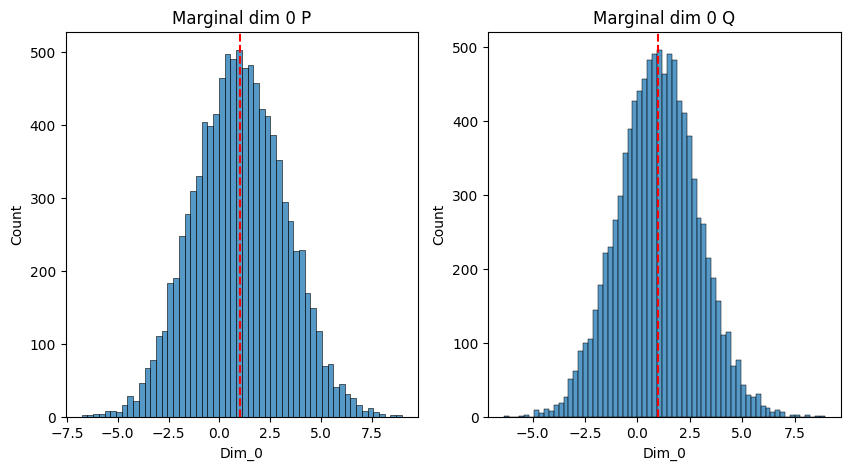

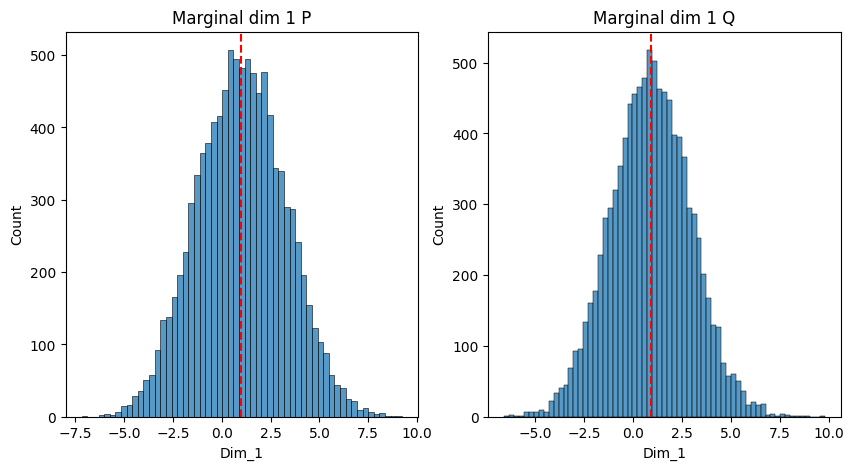

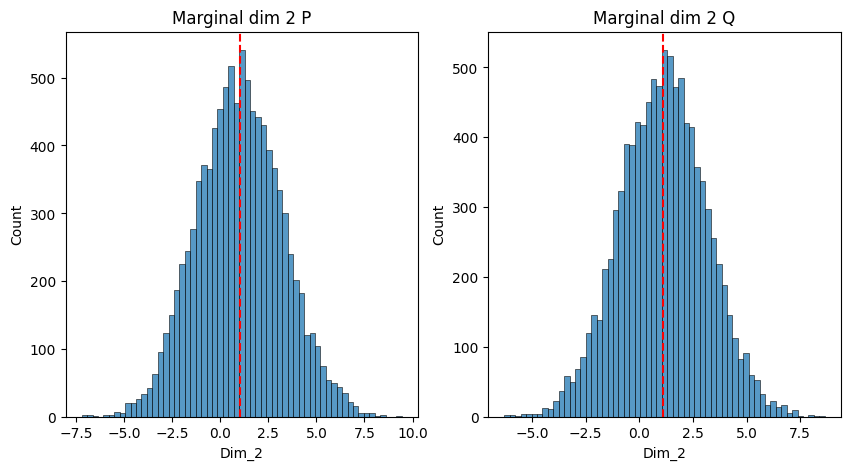

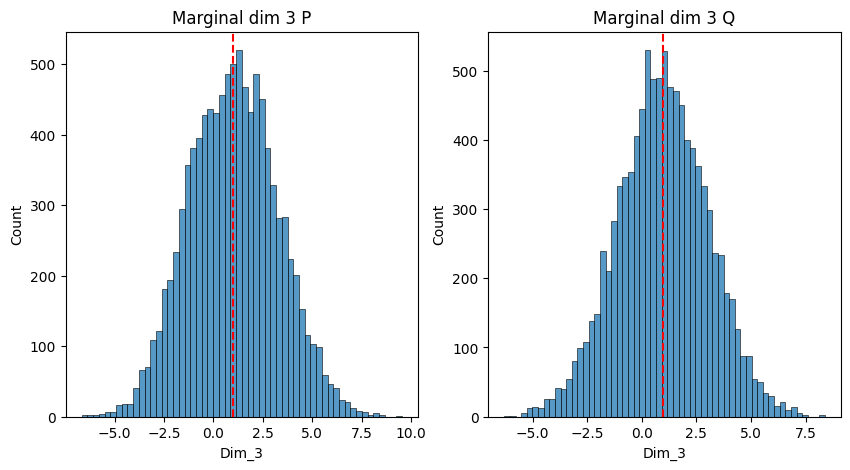

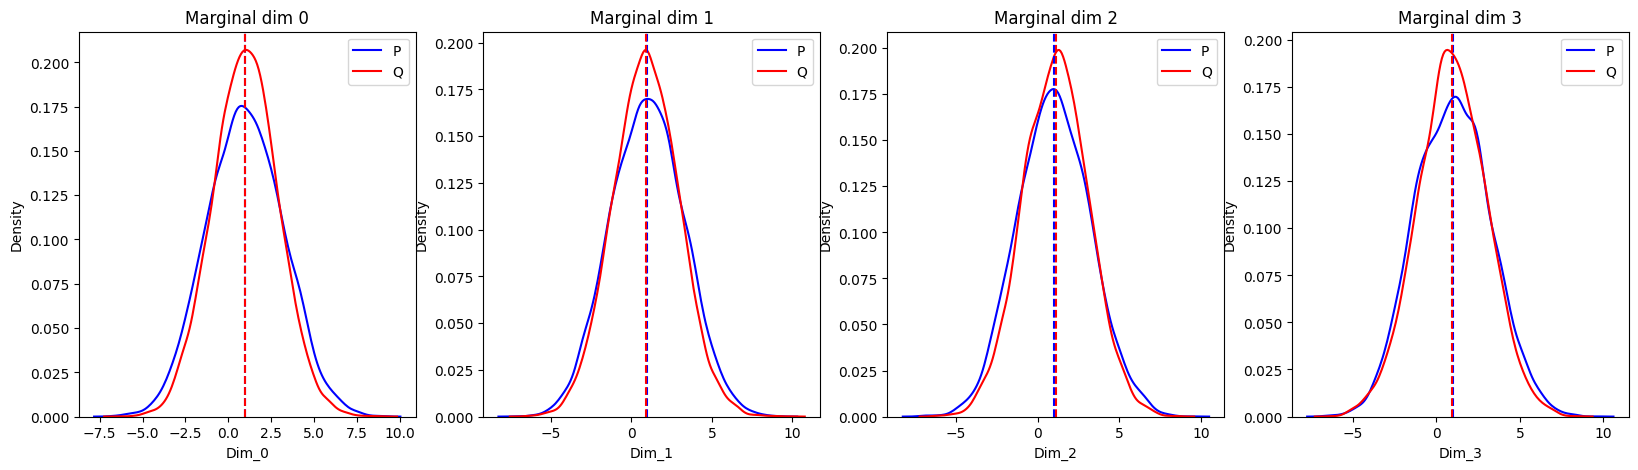

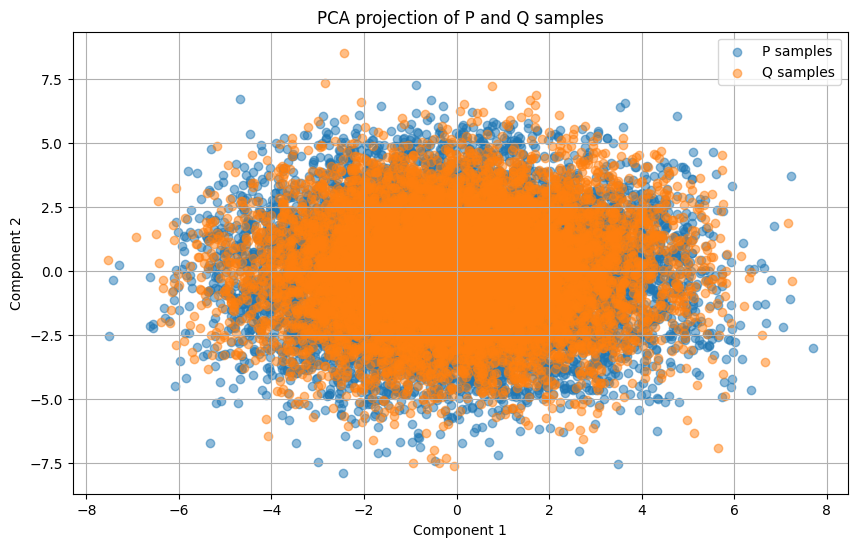

c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\ot\lp\__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


....................


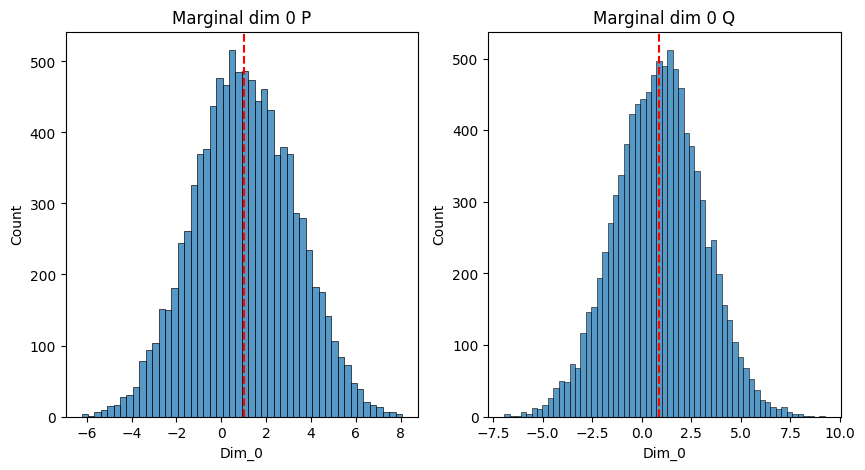

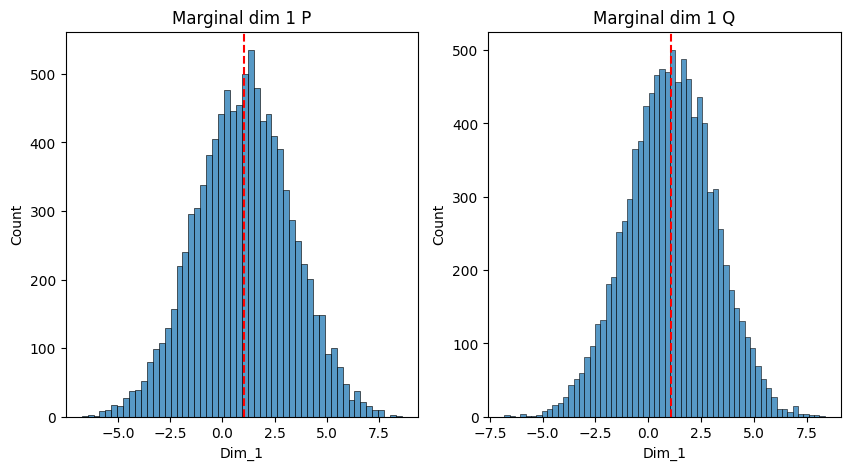

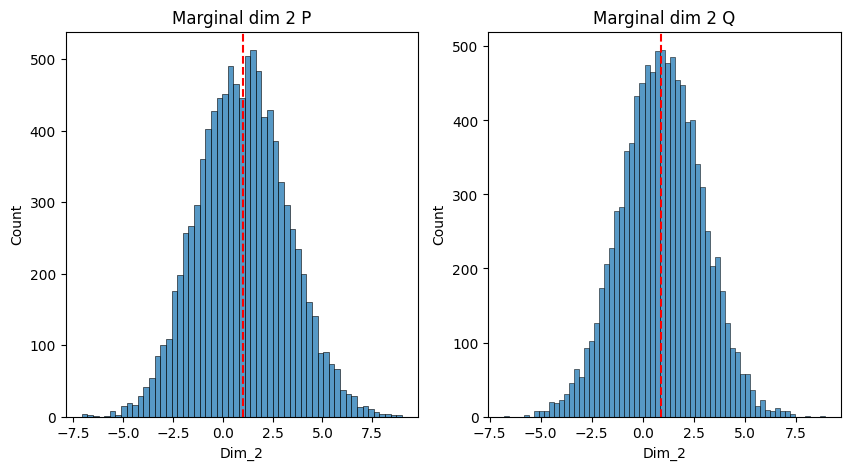

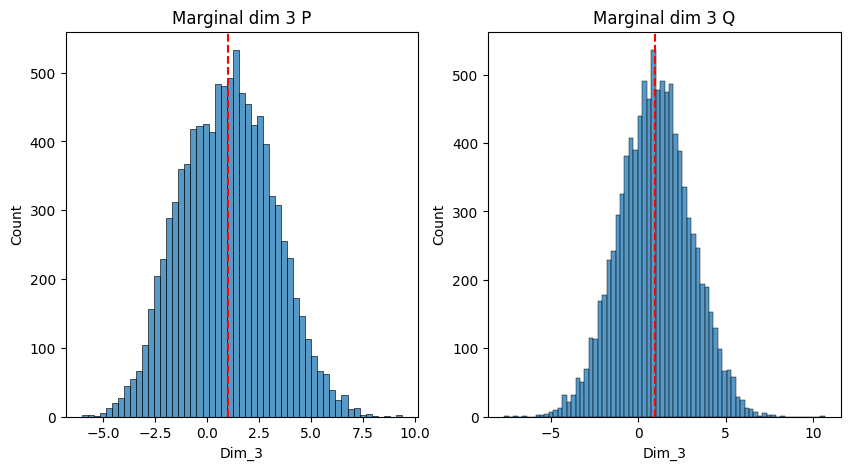

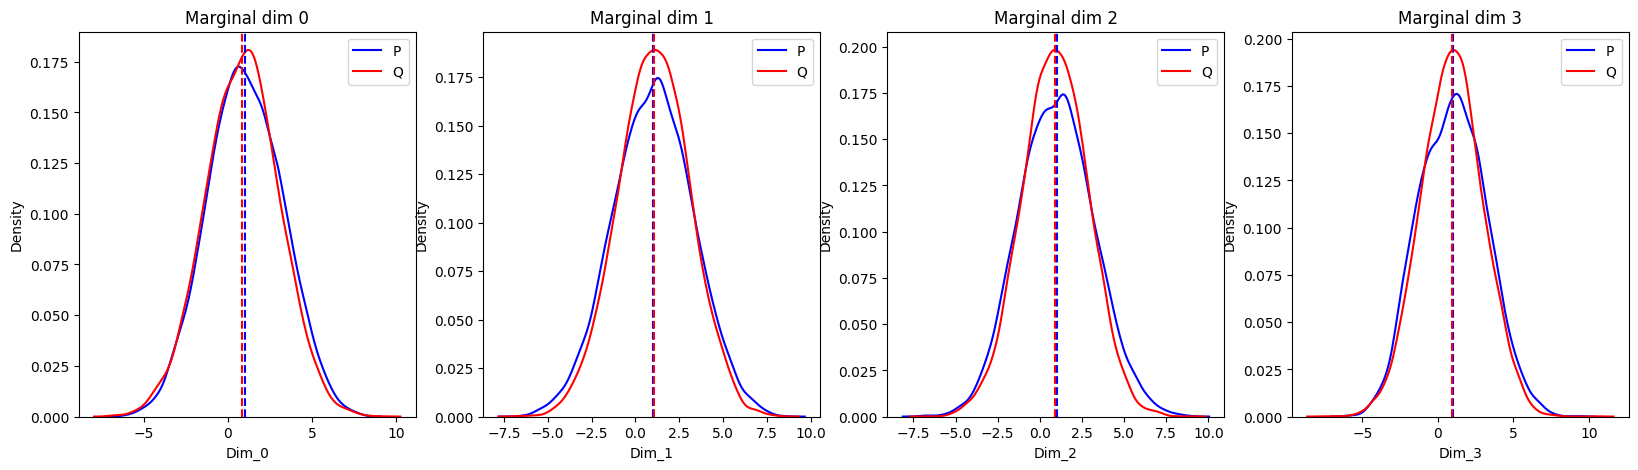

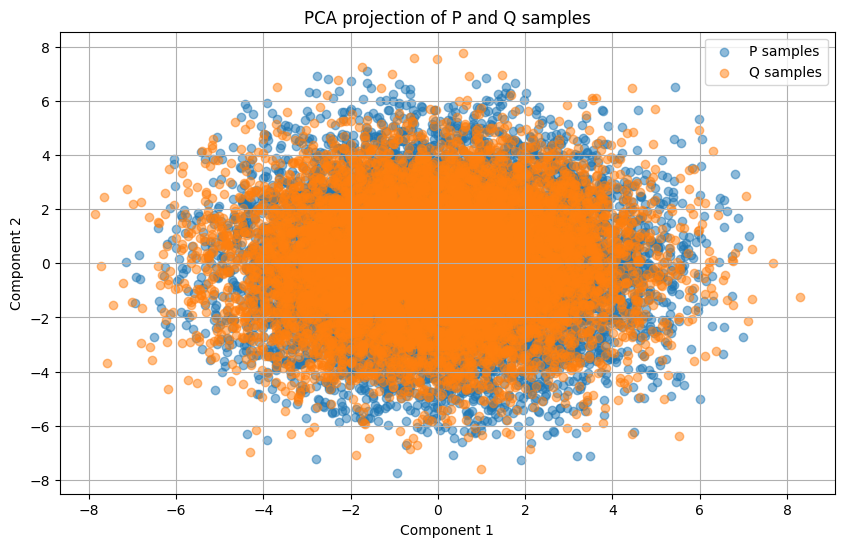

TypeError: 'float' object is not iterable

In [ ]:
comparison_model_vi =  CompareComparisonModels(
    comparison_model_1=full_model,
    comparison_model_2=vi,
    n_samples_comparison_model_1=10_000,
    save_path = trainer.save_path
)

r_vi = comparison_model_vi.compare_sample_metrics_batch(test_batch["x"][:5].cpu(), test_batch["y"][:5].cpu())

In [ ]:
print(r_vi)

([{'CST': {'accuracy': 0.851, 'roc_auc_score': 0.851}, 'MMD': 0.382432222366333, 'Wasserstein_distance with metric euclidean': 0.44791263341903687, 'mean_stats': {'absolute_mean_diff': tensor(0.0558), 'squared_mean_diff': tensor(0.0045), 'P_mean': tensor([-1.0746,  0.6922,  0.1665, -0.3666, -0.5925, -0.6509, -0.9716,  1.7523,
        -0.4697, -1.4973]), 'Q_mean': tensor([-0.9776,  0.7030,  0.2077, -0.3230, -0.5999, -0.7305, -0.9898,  1.6816,
        -0.3448, -1.4322])}, 'std_stats': {'absolute_std_diff': tensor(0.0654), 'squared_std_diff': tensor(0.0044), 'P_std': tensor([0.2018, 0.1914, 0.1939, 0.2014, 0.1959, 0.1951, 0.2007, 0.2001, 0.2074,
        0.2023]), 'Q_std': tensor([0.1268, 0.1334, 0.1499, 0.1359, 0.1262, 0.1344, 0.1170, 0.1246, 0.1604,
        0.1269])}, 'q_025_stats': {'absolute_q_025_diff': tensor(0.1429), 'squared_q_025_diff': tensor(0.0250), 'P_q_025': tensor([-1.4545,  0.3094, -0.1885, -0.7536, -0.9733, -1.0300, -1.3322,  1.3717,
        -0.8687, -1.9311]), 'Q_q_025': 

In [ ]:
comparison_model_comparer = CompareComparisonModels(
    comparison_model_1=vi,
    comparison_model_2=hmc_sampler,
    n_samples_comparison_model_1=1000,
    save_path = trainer.save_path
)

.

/usr/local/lib/python3.10/dist-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta_var'}
  warnings.warn(


...................


Sample: 100%|██████████| 800/800 [00:55, 14.32it/s, step size=1.86e-01, acc. prob=0.930]


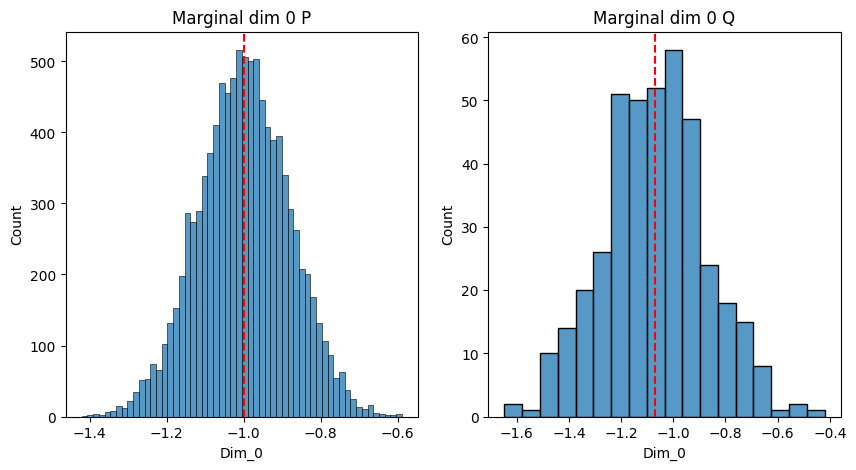

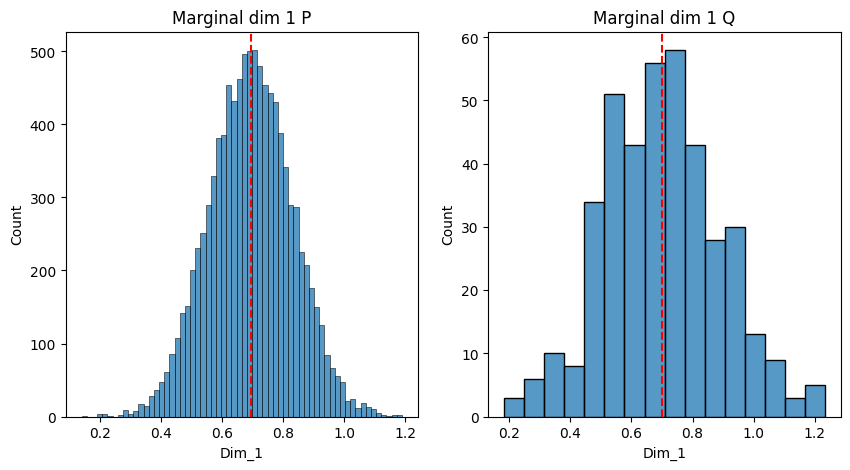

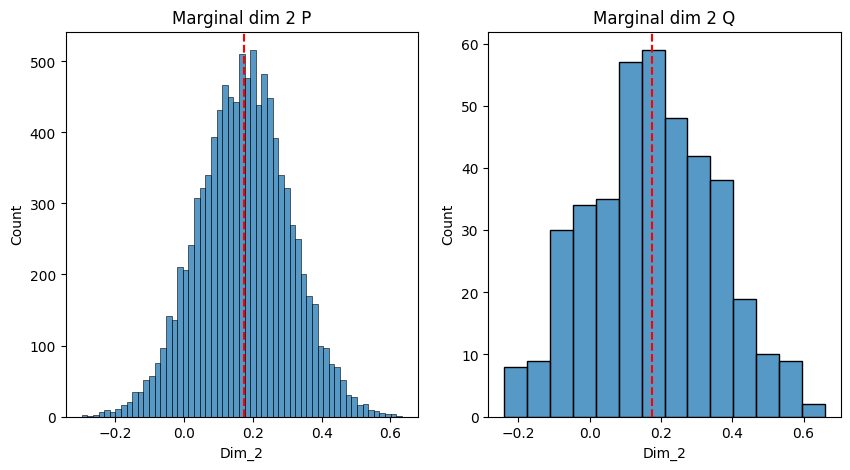

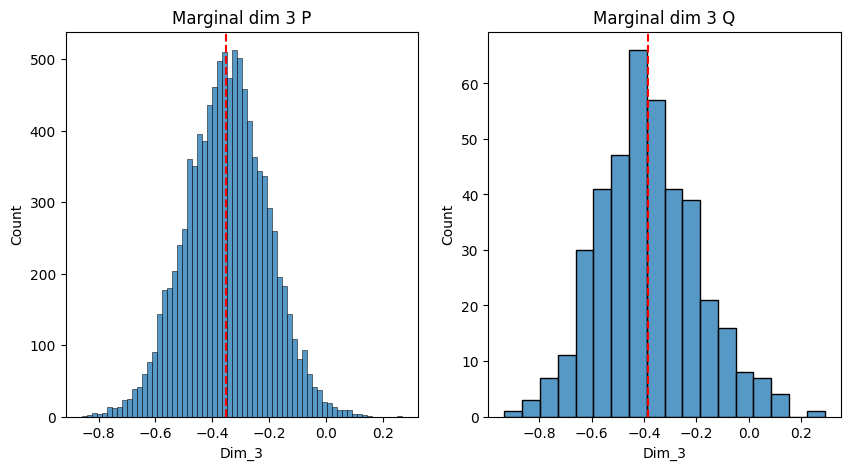

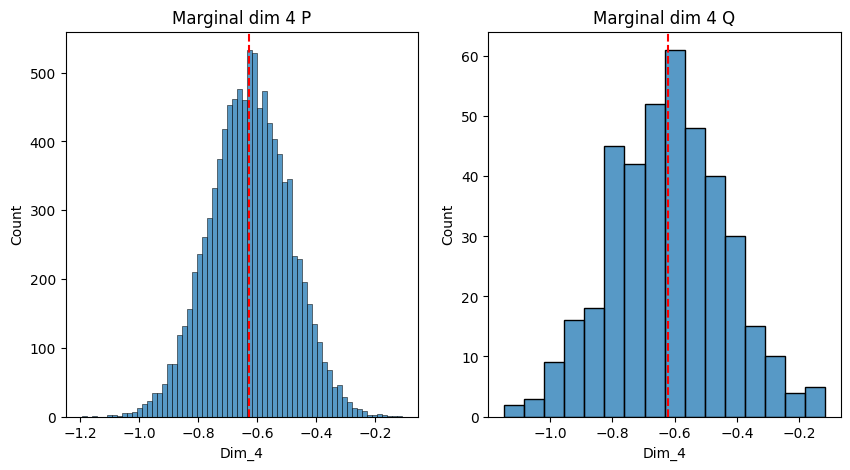

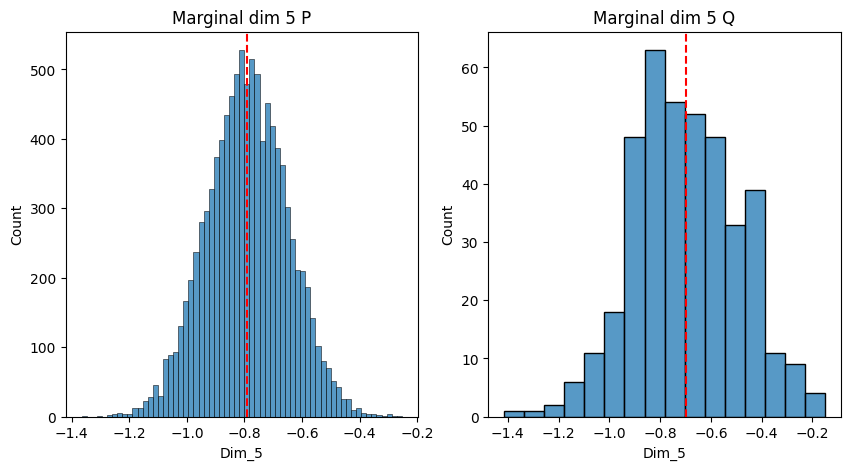

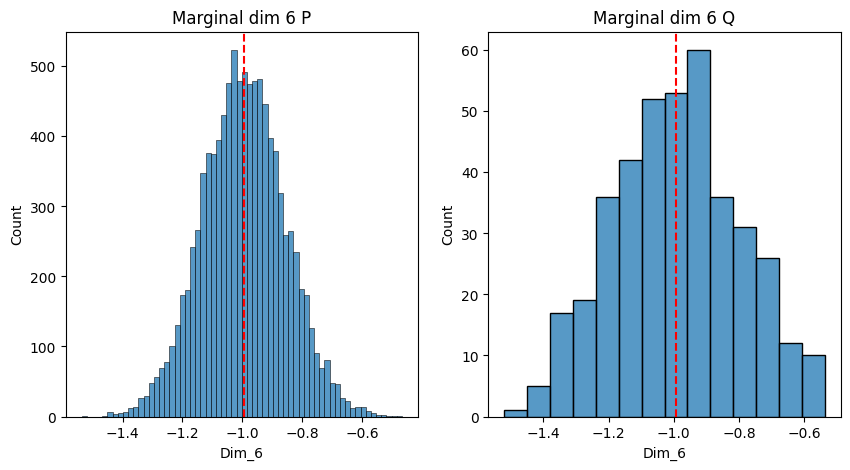

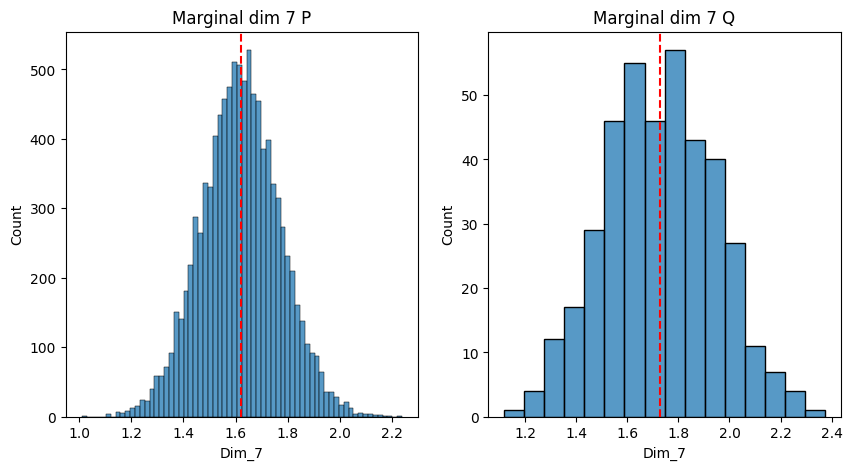

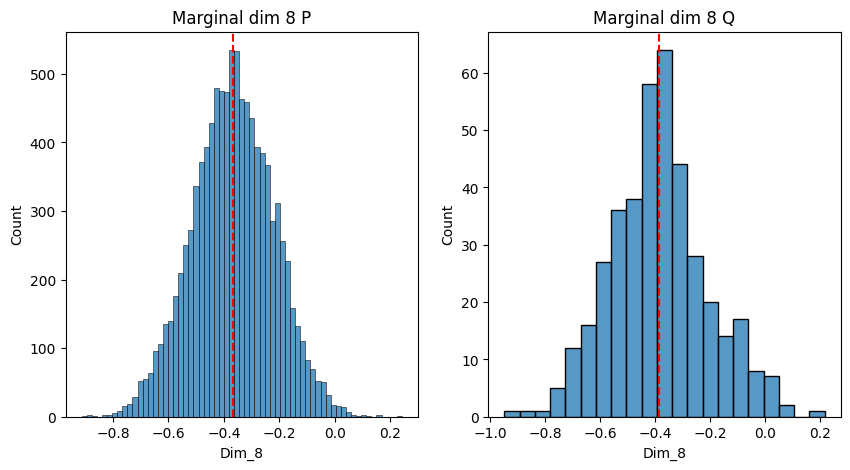

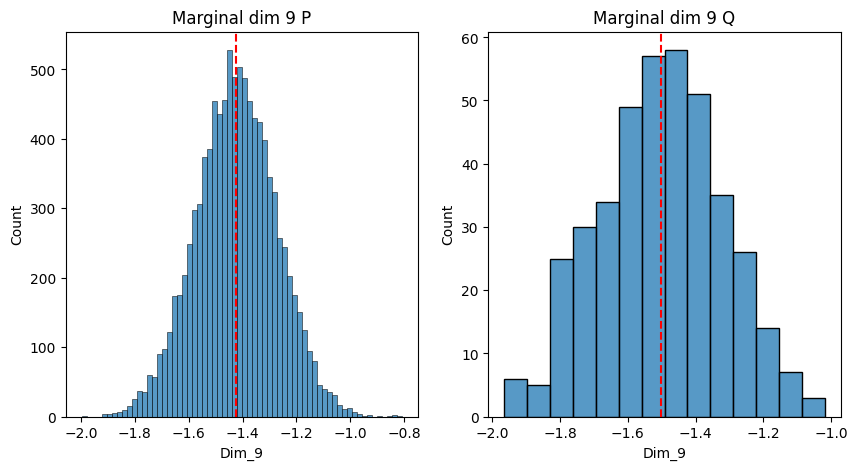

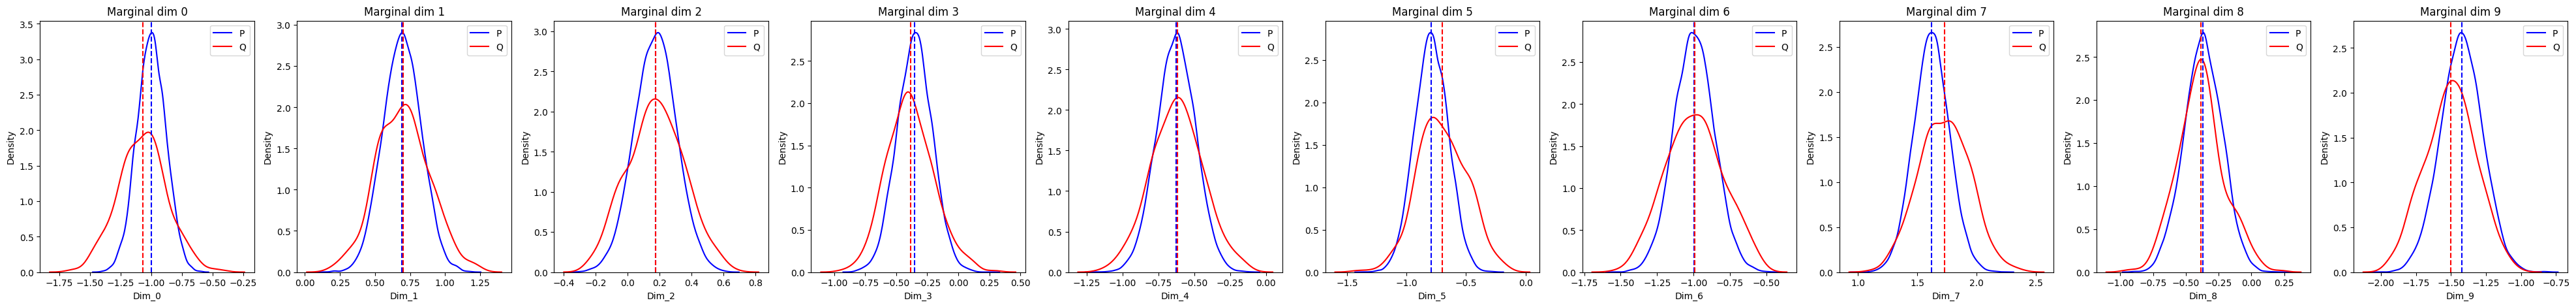

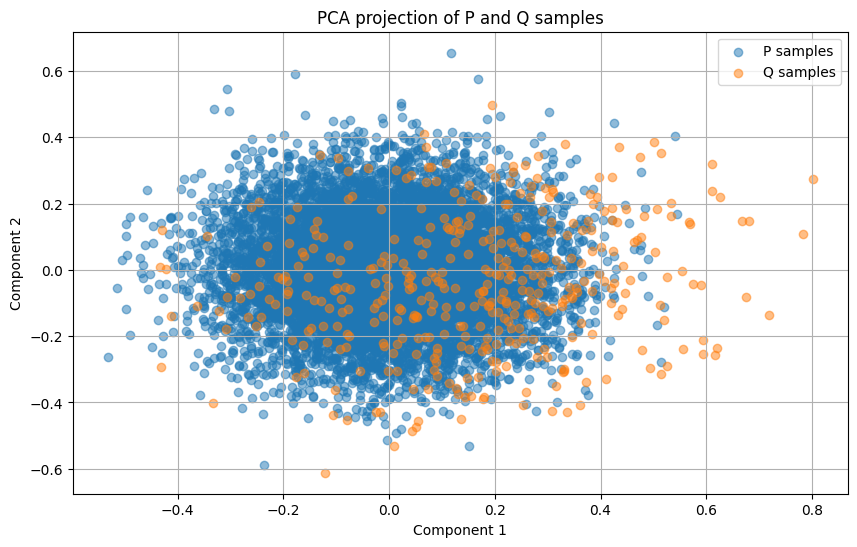

/usr/local/lib/python3.10/dist-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta_var'}
  warnings.warn(


....................


Sample: 100%|██████████| 800/800 [00:49, 16.22it/s, step size=2.02e-01, acc. prob=0.926]


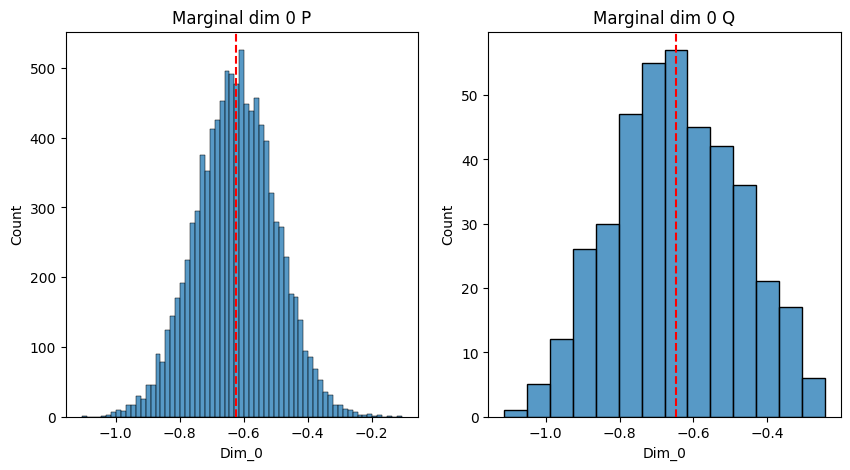

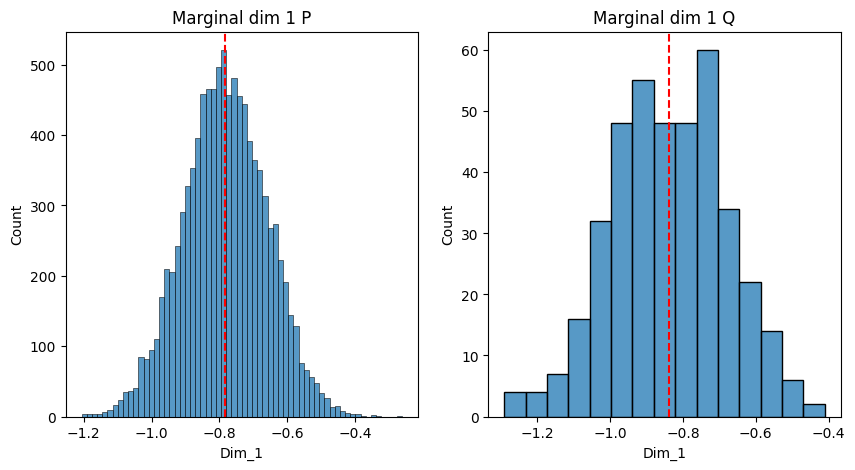

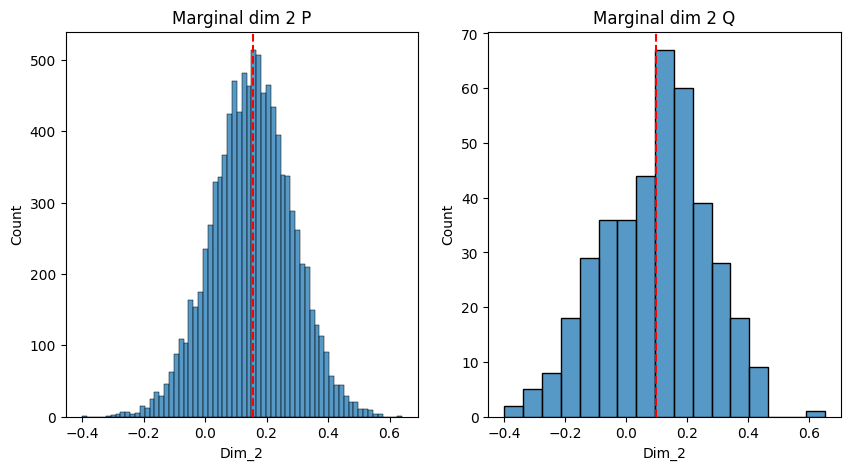

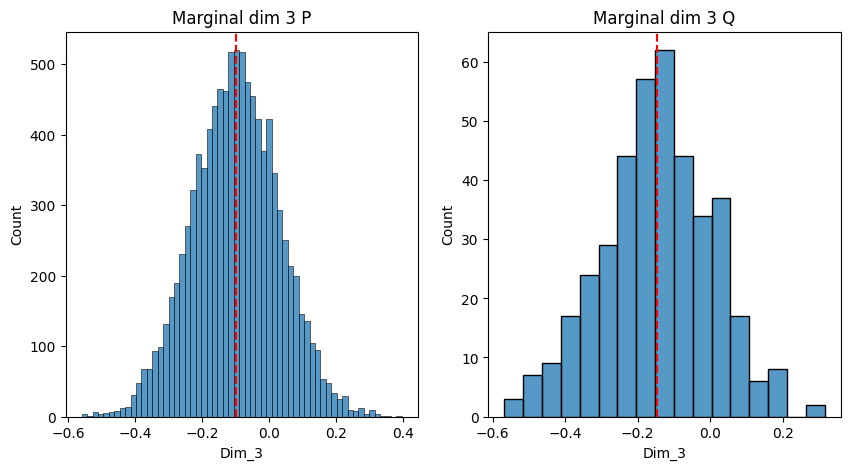

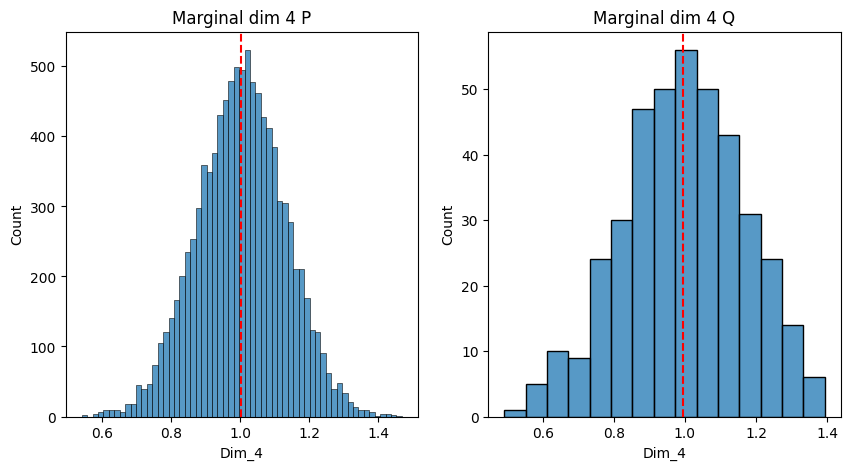

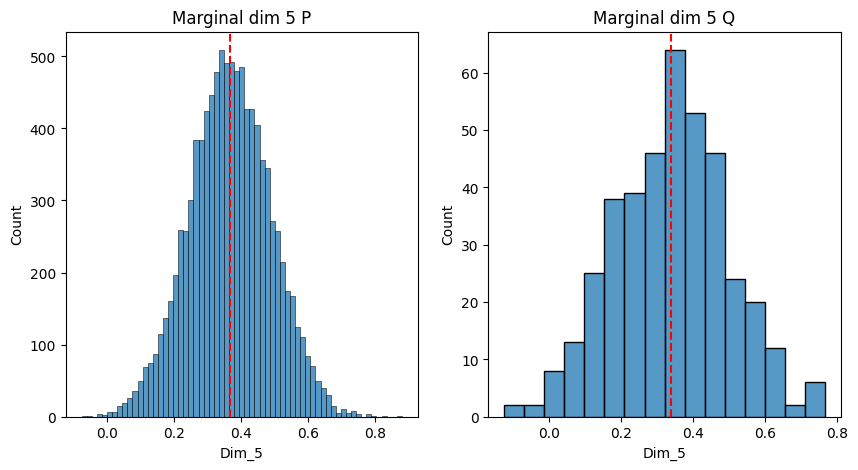

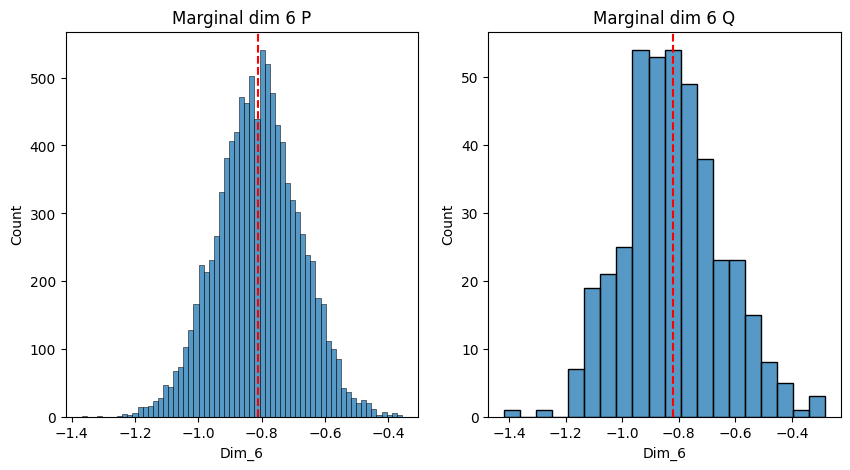

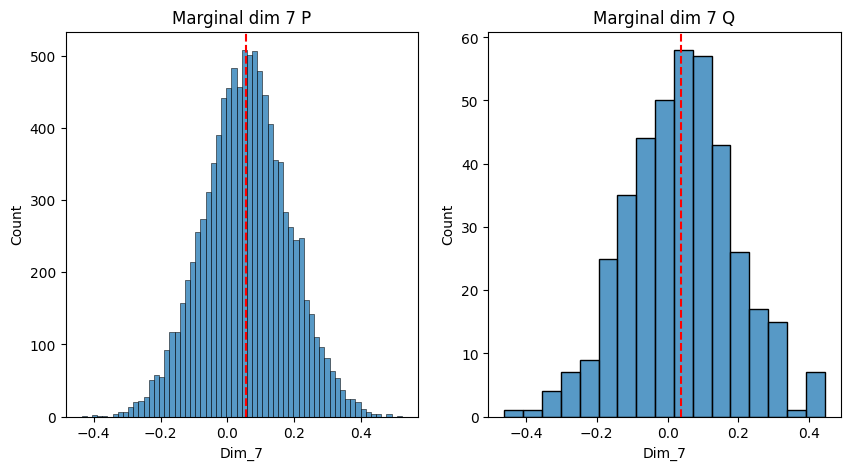

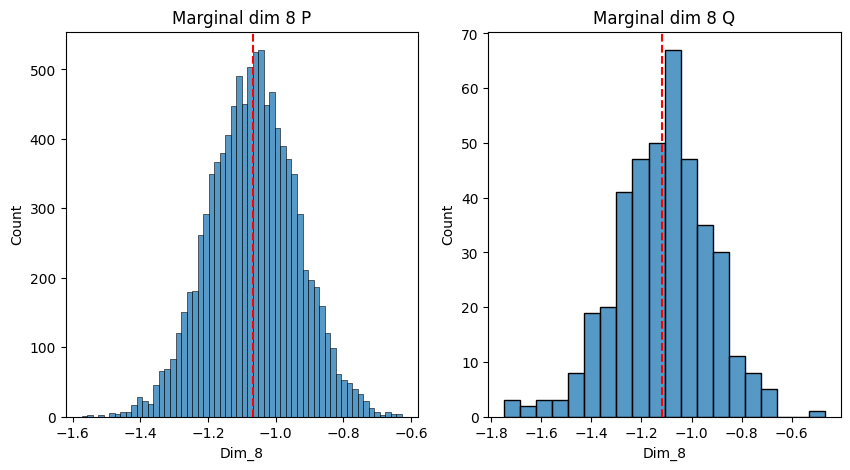

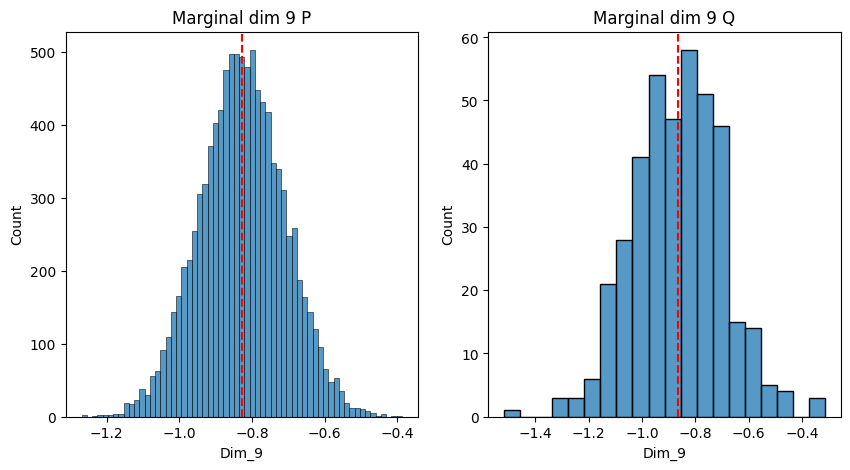

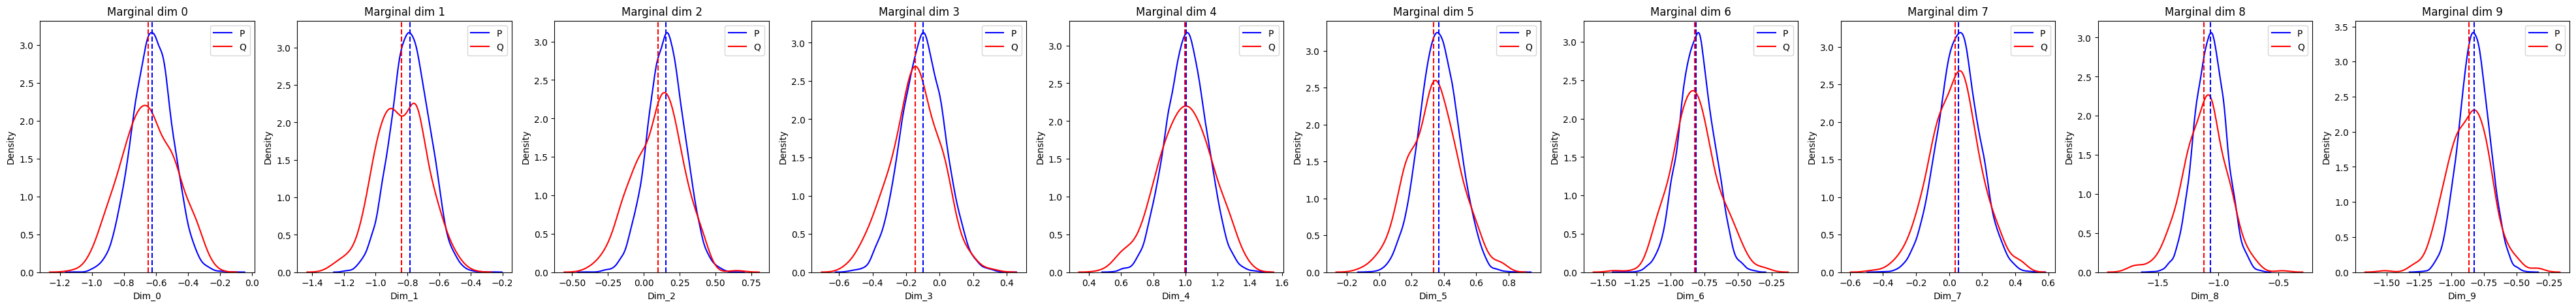

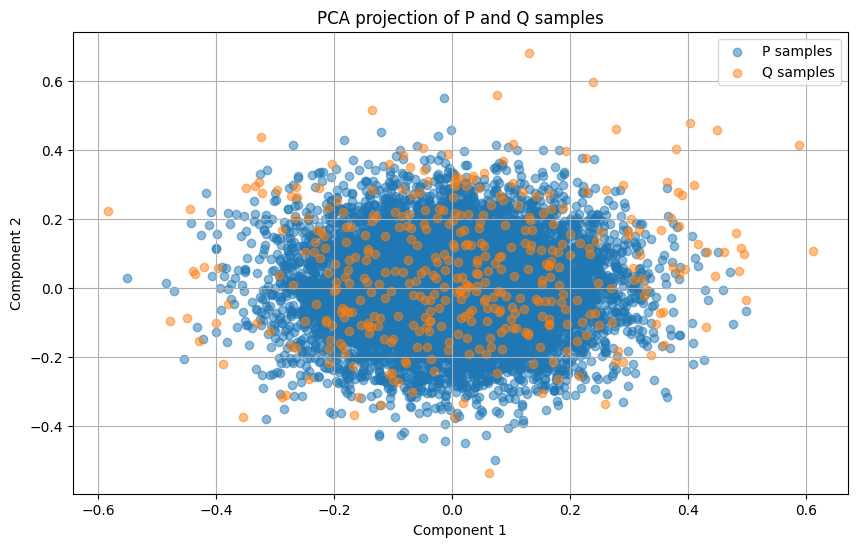

/usr/local/lib/python3.10/dist-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta_var'}
  warnings.warn(


....................


Sample: 100%|██████████| 800/800 [00:58, 13.71it/s, step size=1.69e-01, acc. prob=0.944]


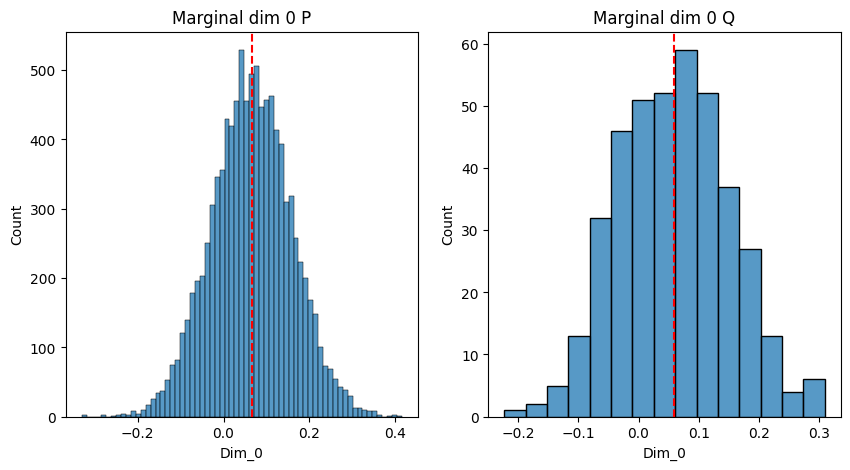

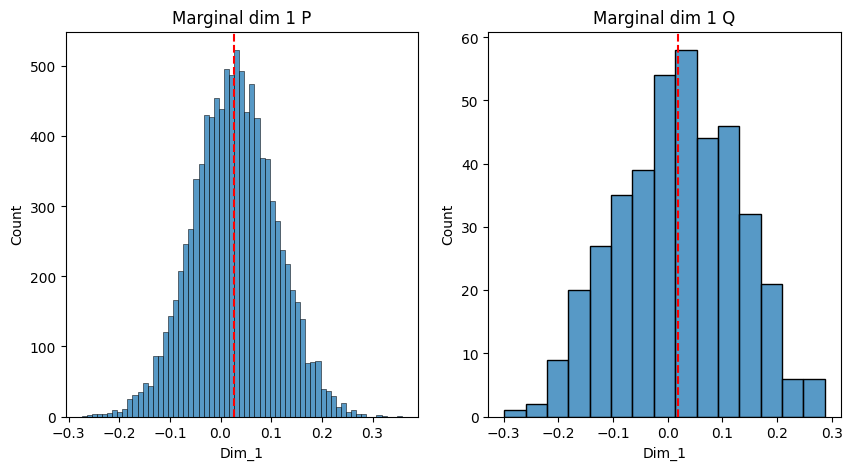

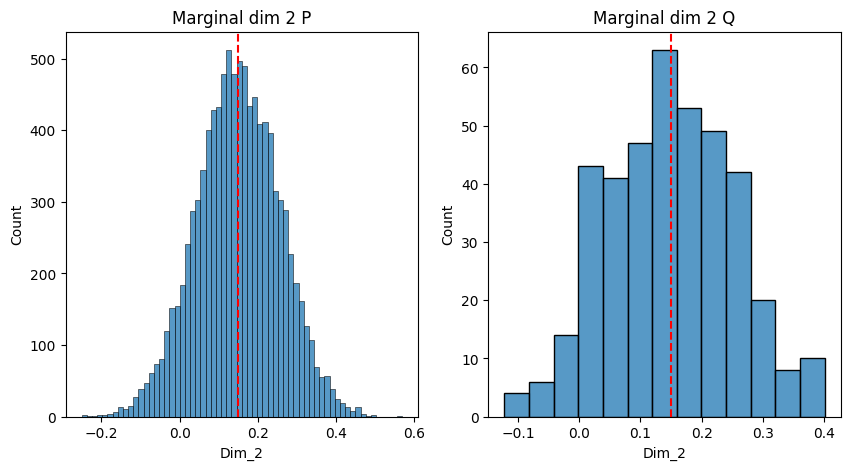

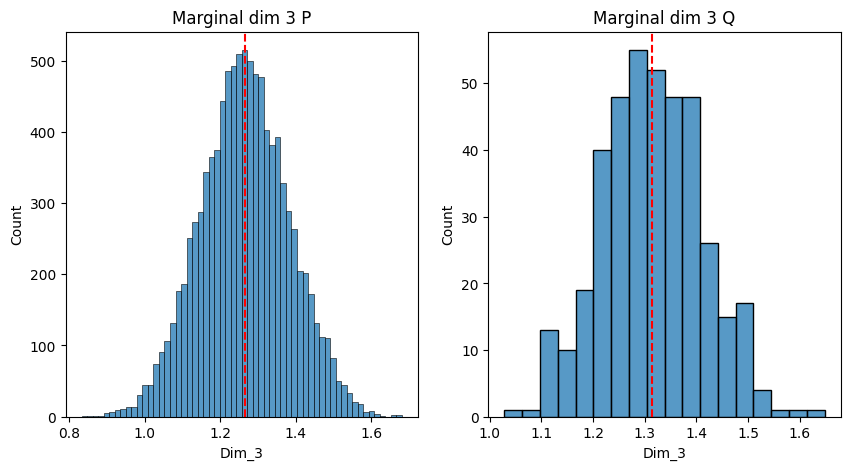

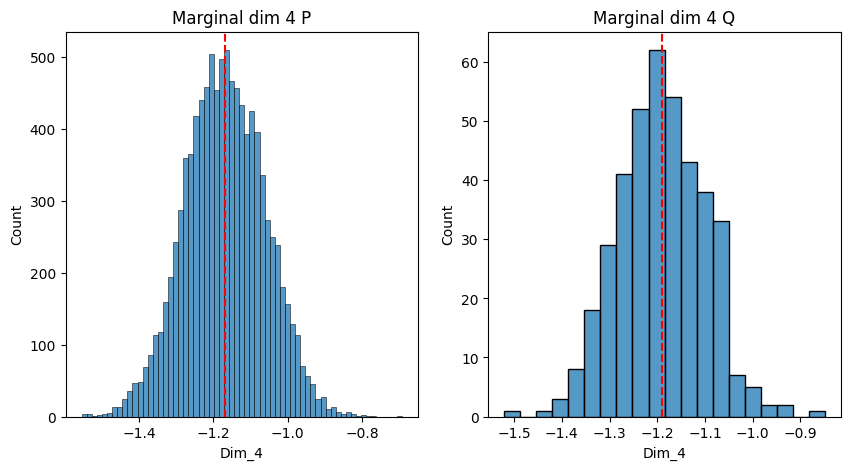

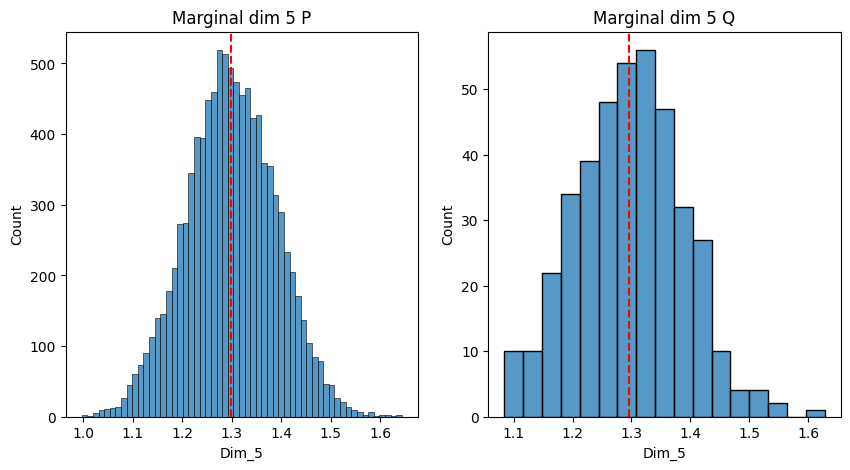

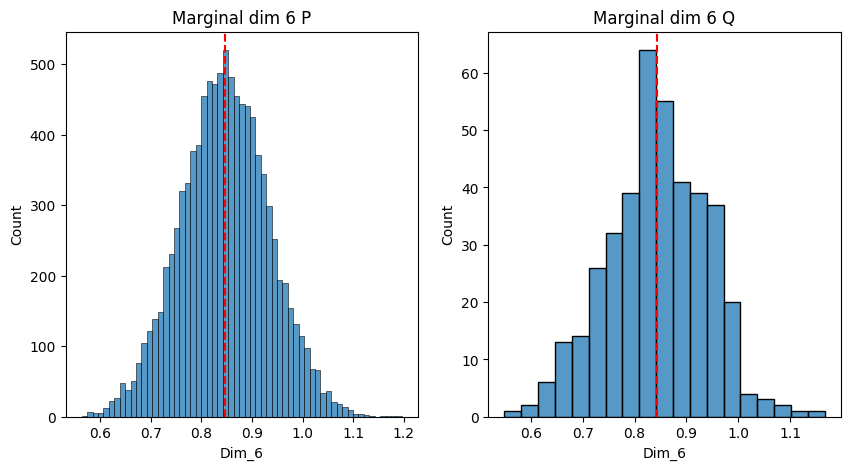

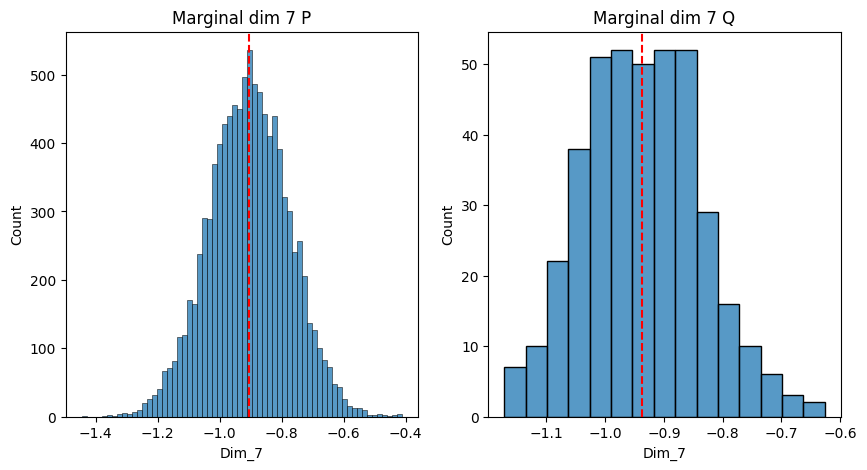

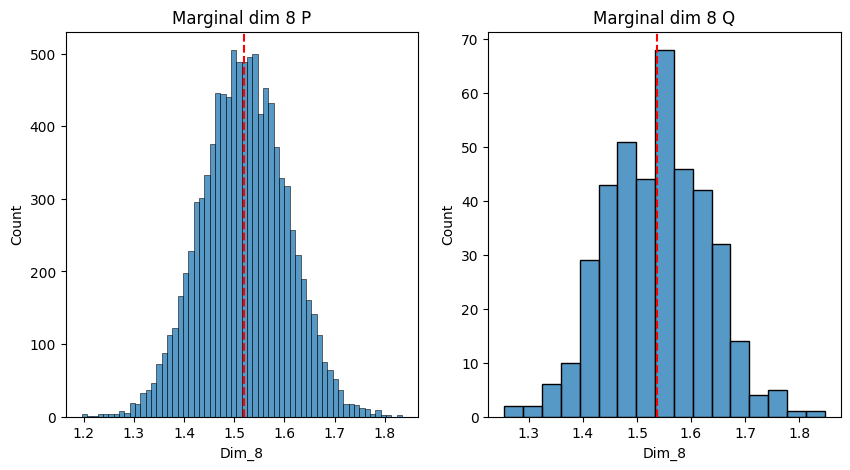

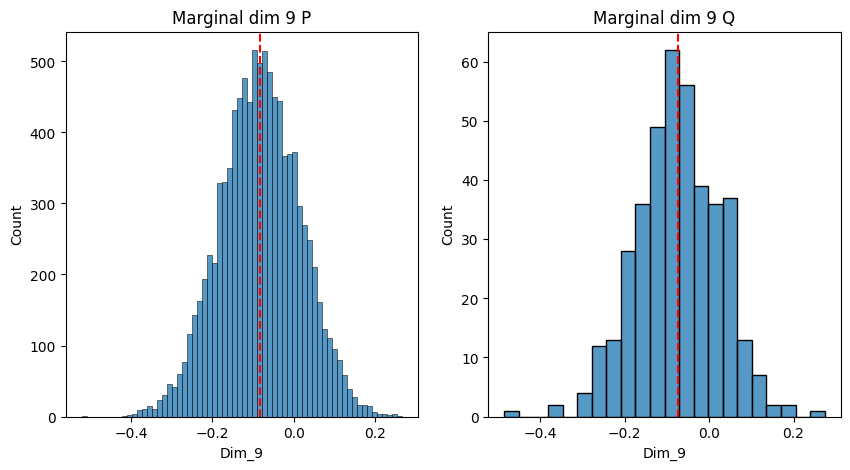

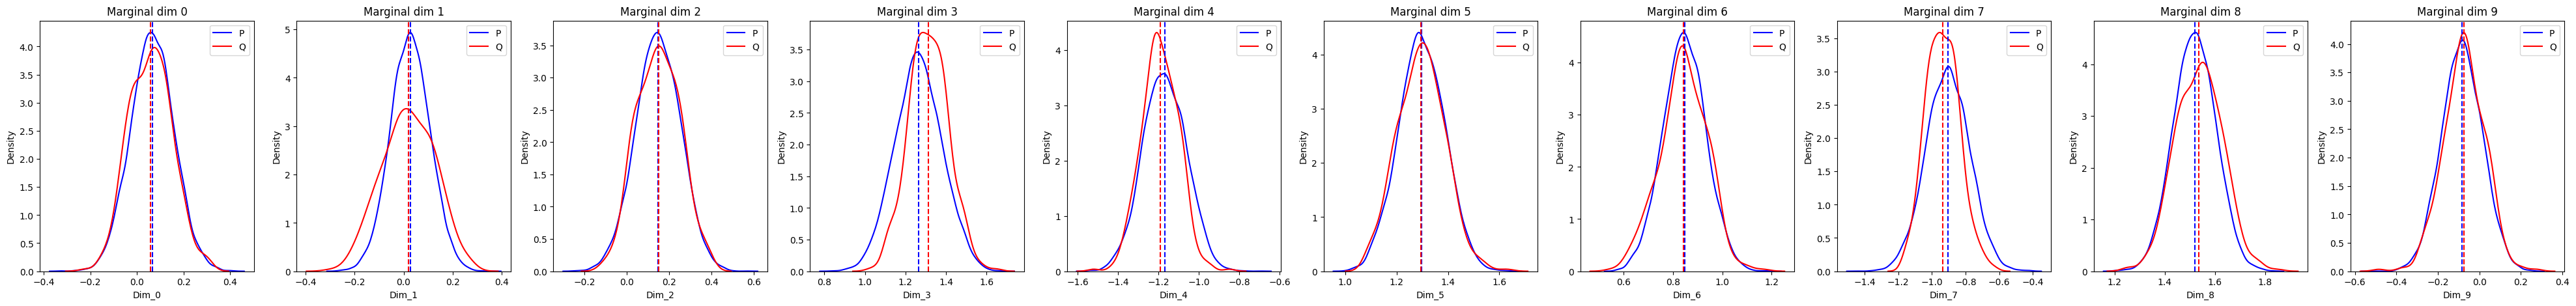

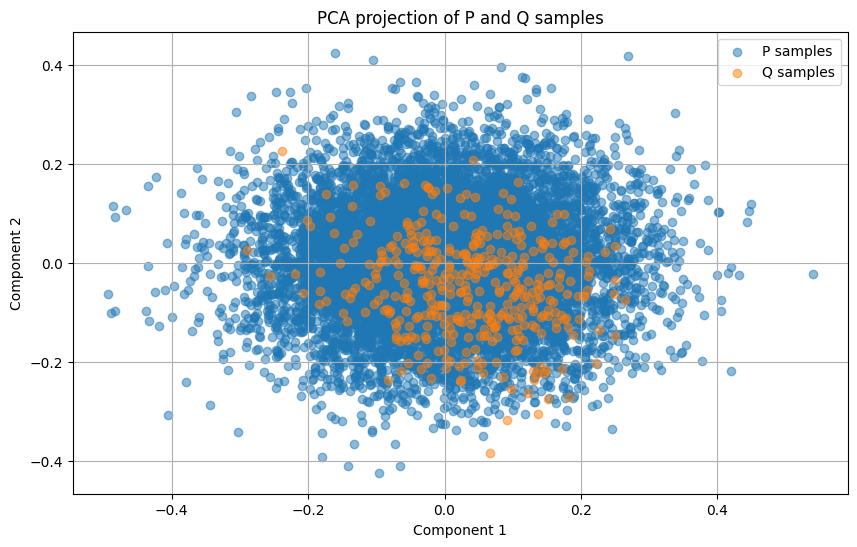

/usr/local/lib/python3.10/dist-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta_var'}
  warnings.warn(


....................


Sample: 100%|██████████| 800/800 [00:58, 13.70it/s, step size=1.85e-01, acc. prob=0.934]


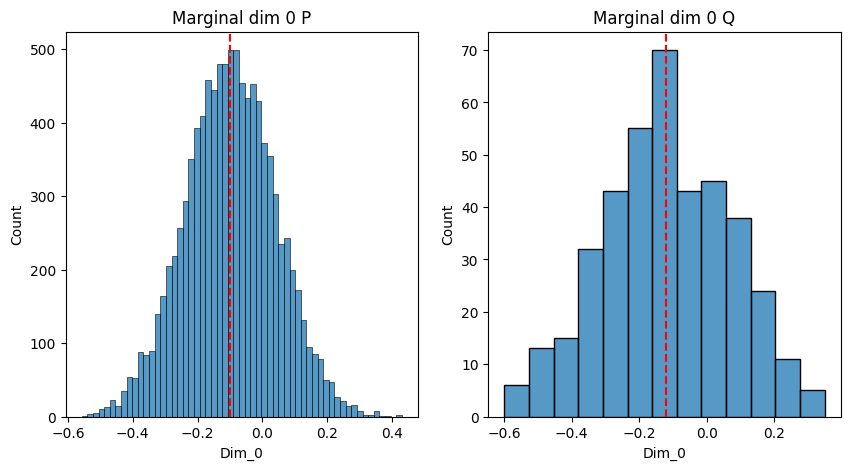

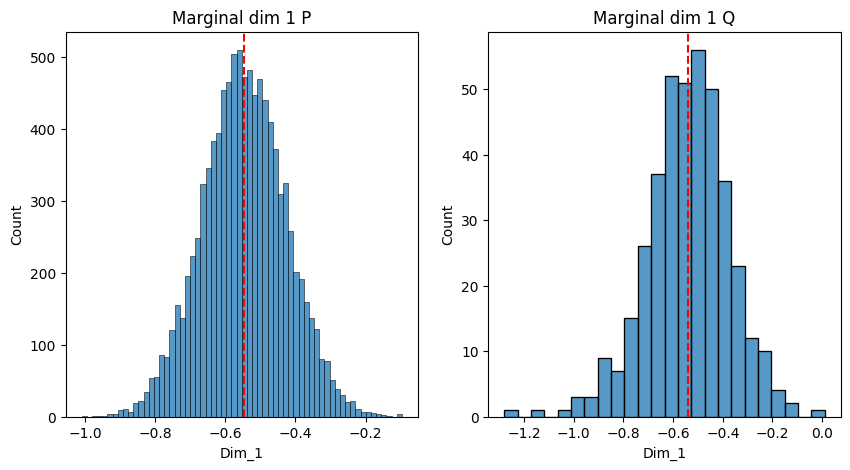

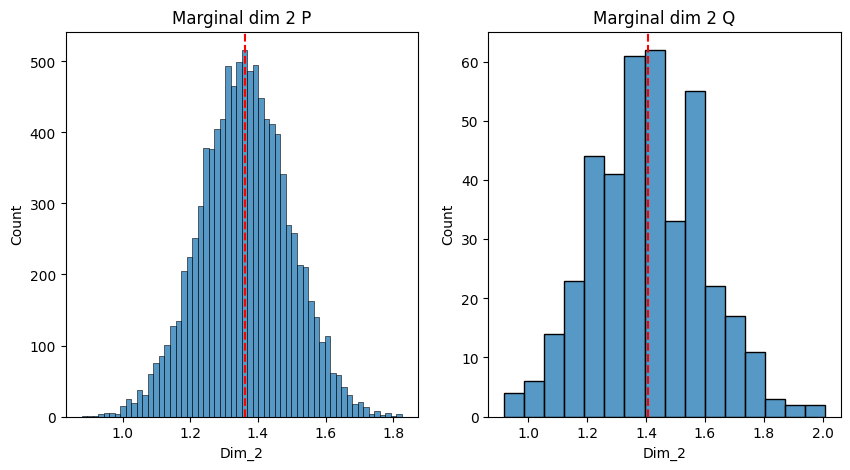

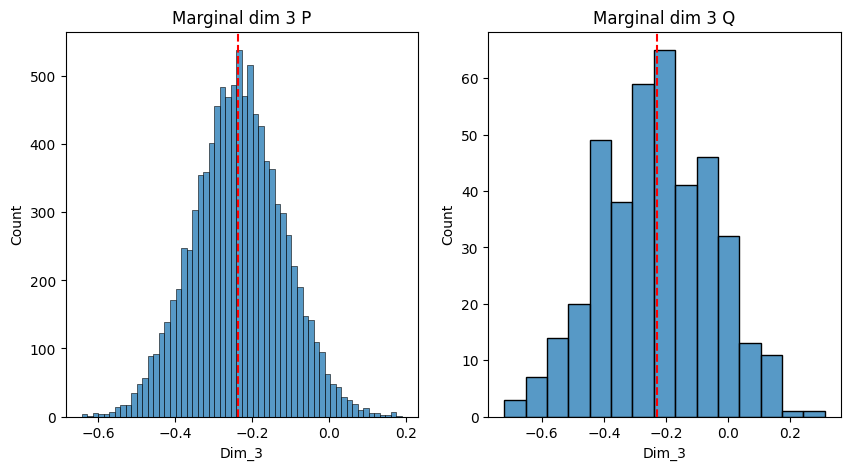

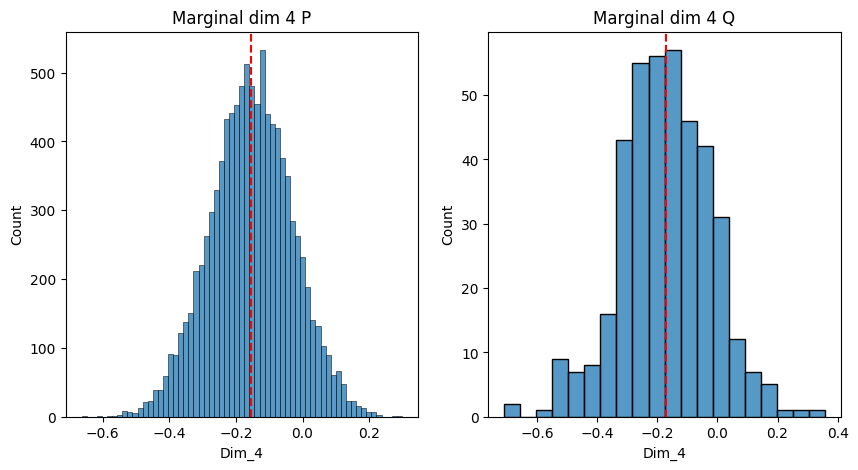

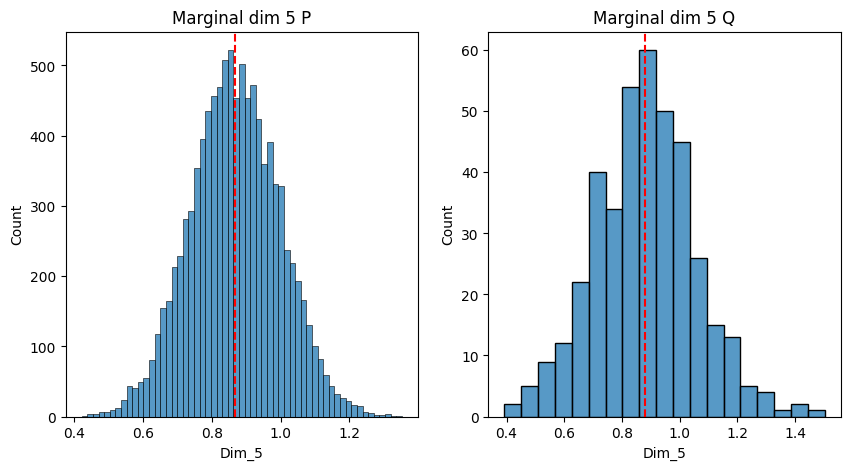

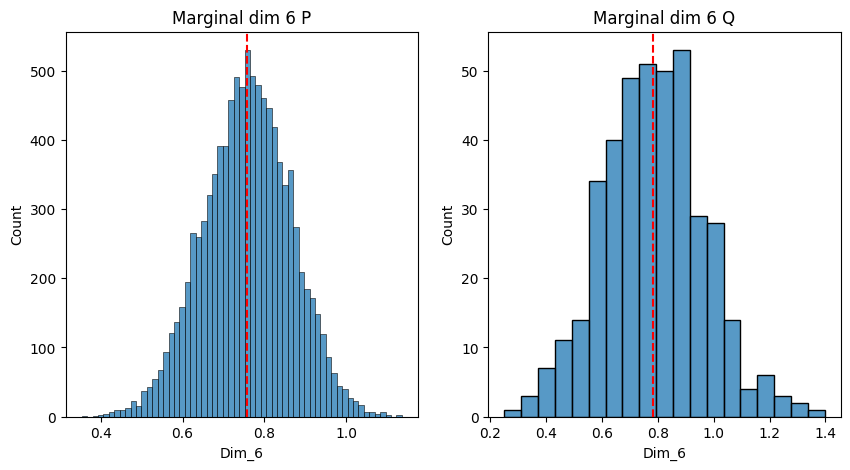

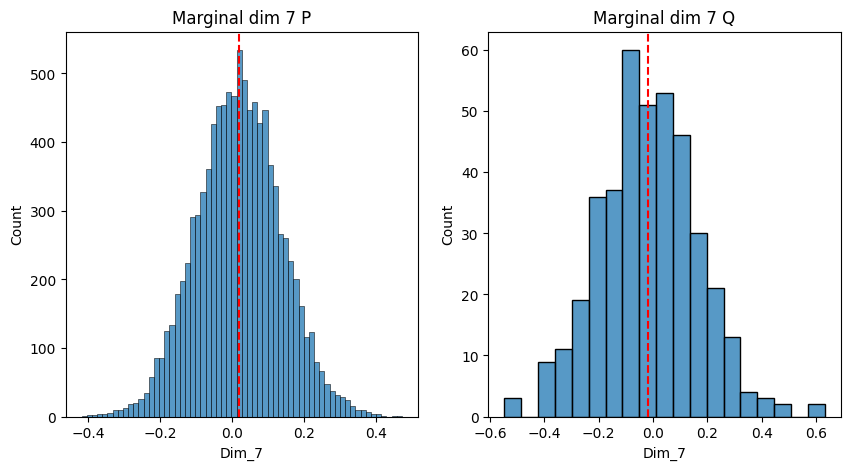

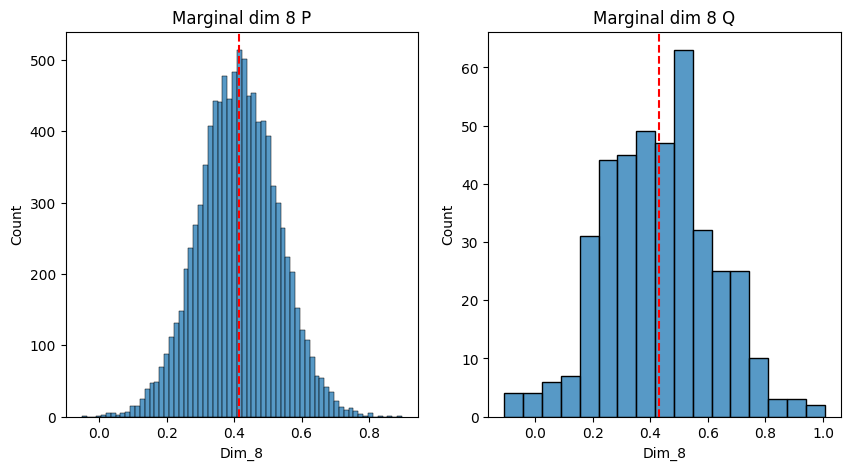

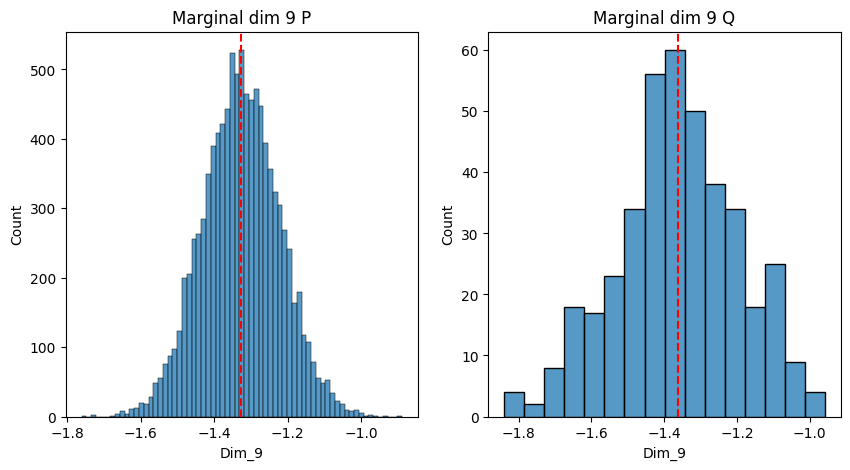

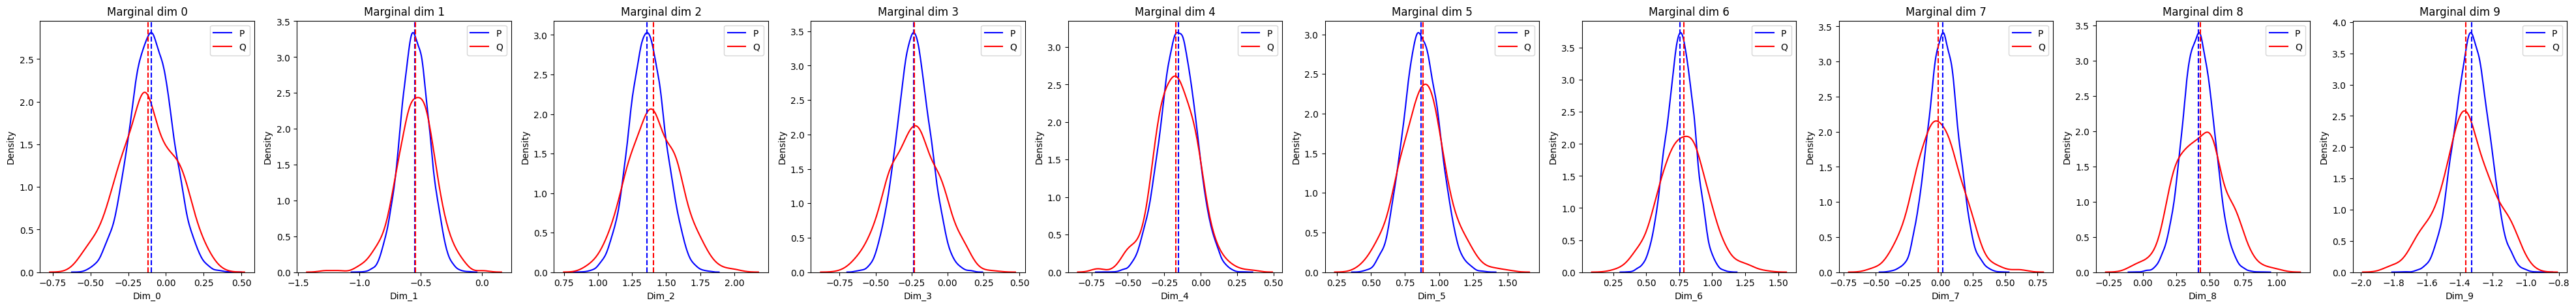

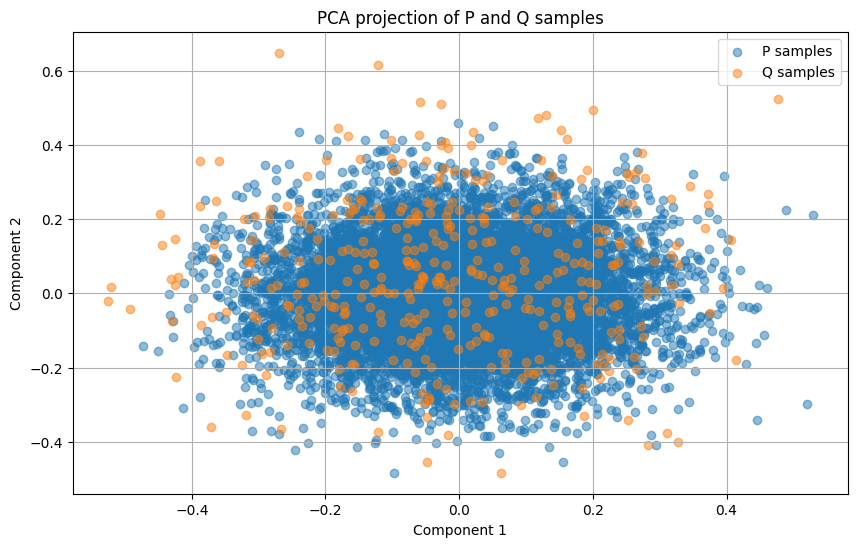

/usr/local/lib/python3.10/dist-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta_var'}
  warnings.warn(


....................


Sample: 100%|██████████| 800/800 [01:02, 12.74it/s, step size=1.65e-01, acc. prob=0.942]


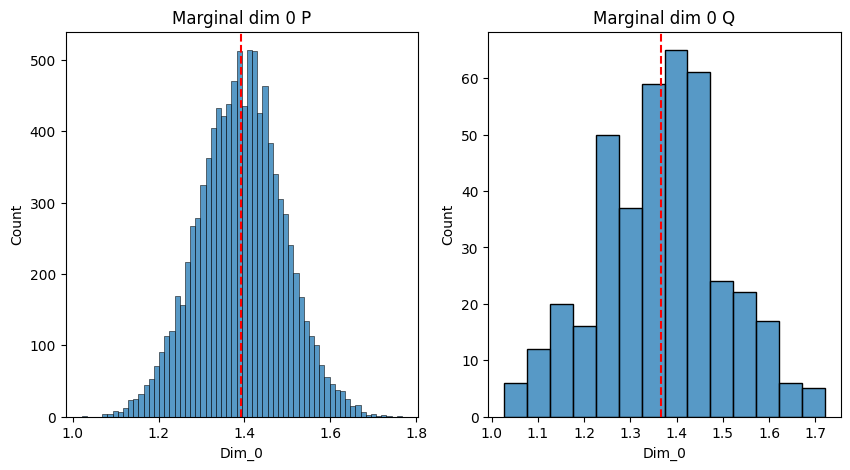

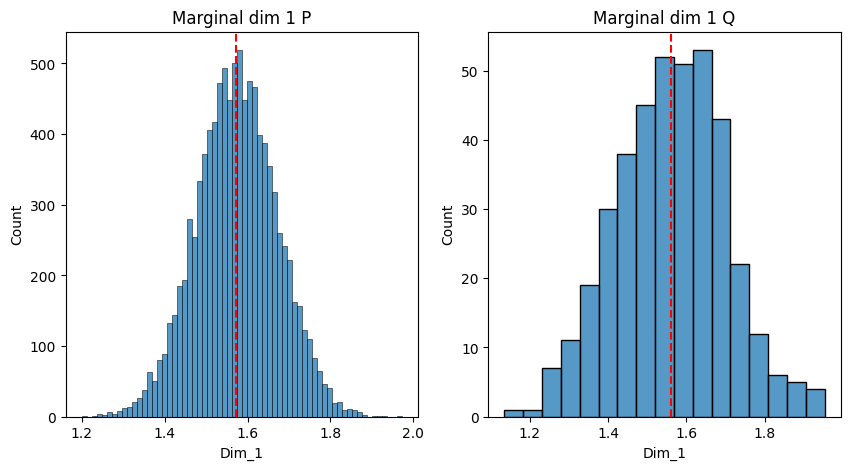

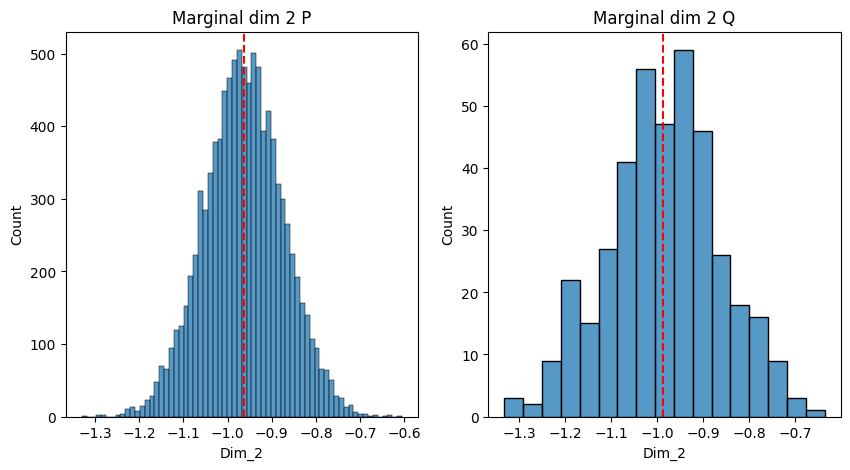

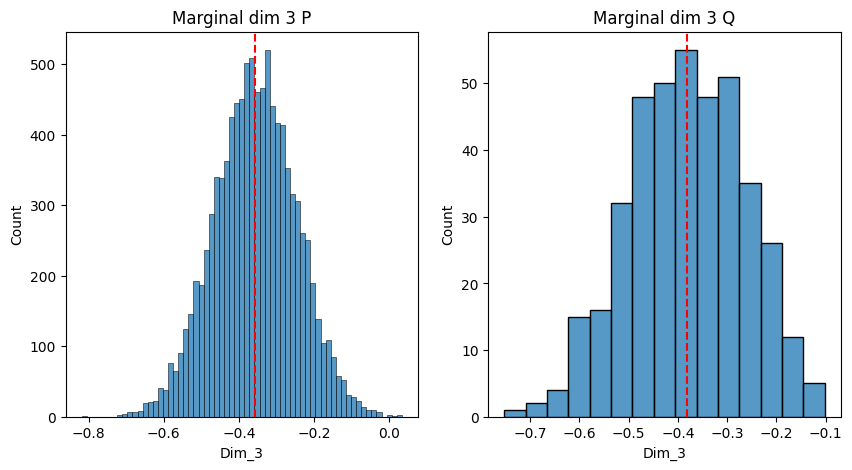

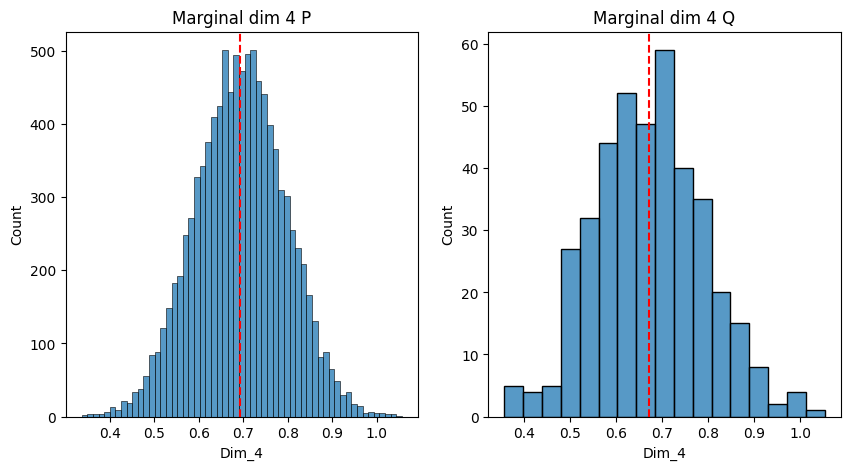

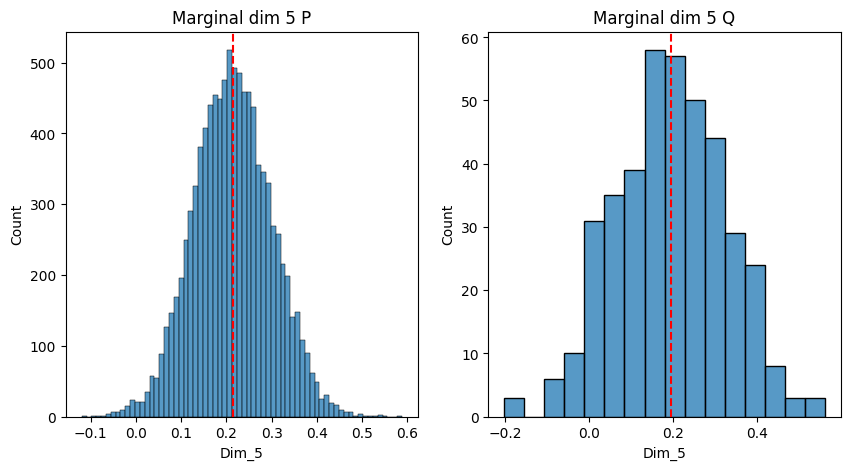

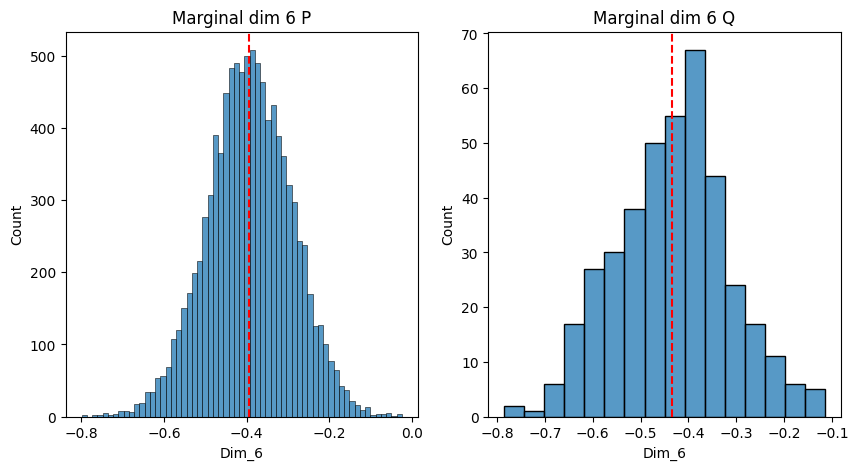

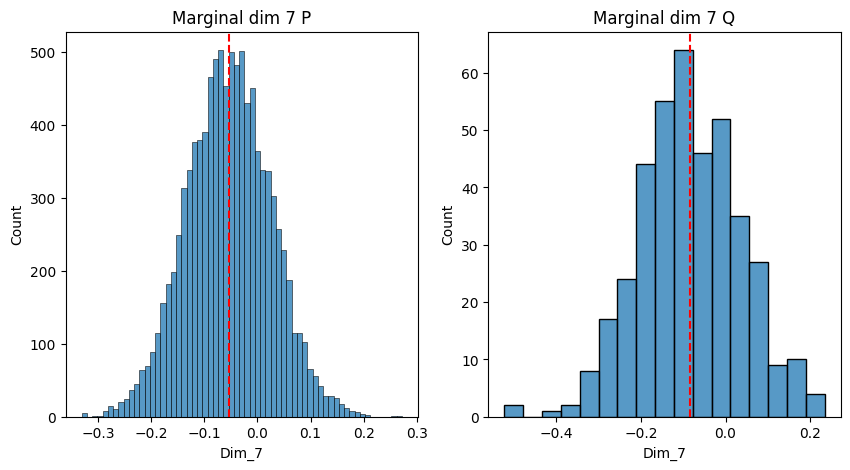

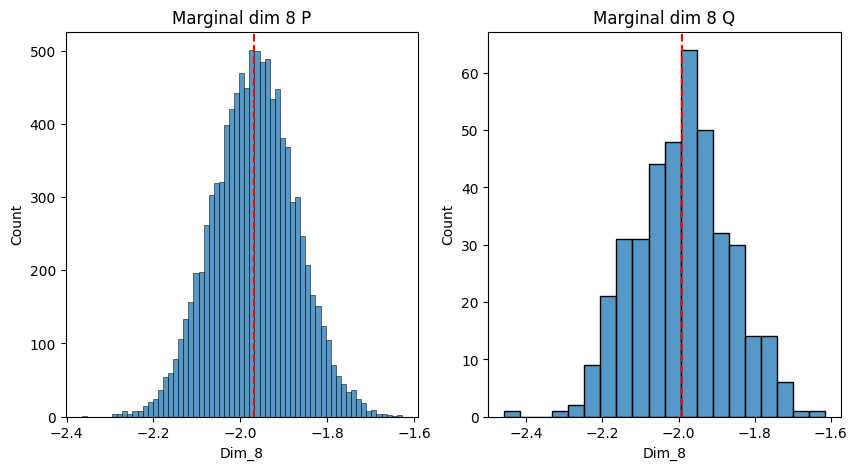

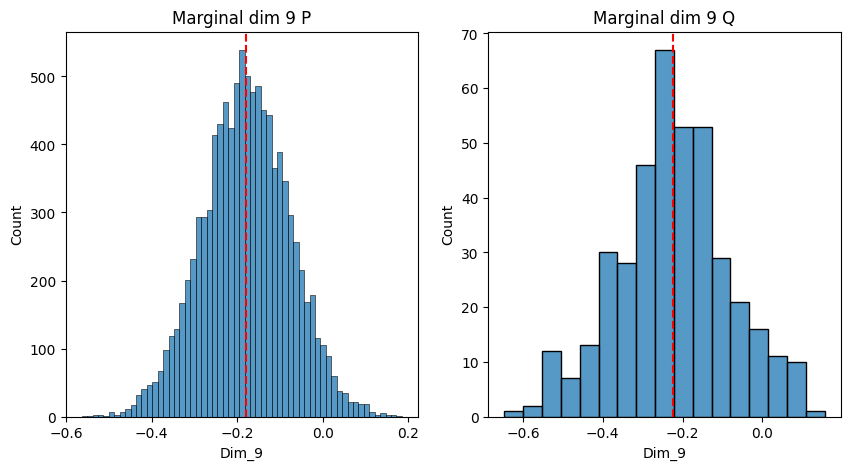

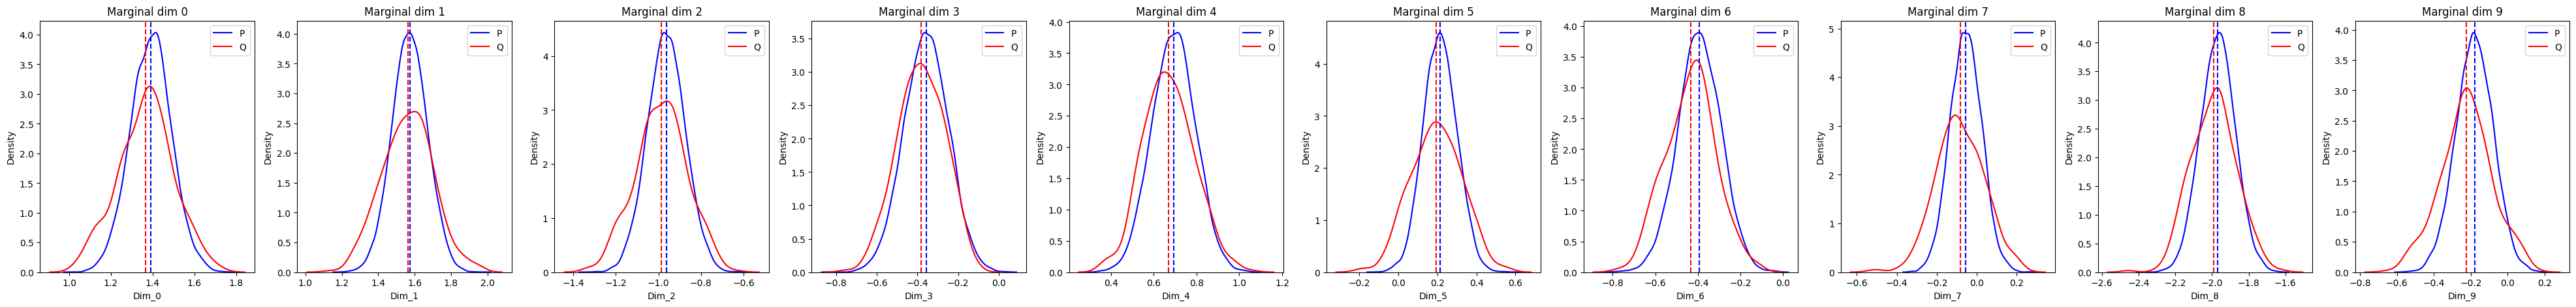

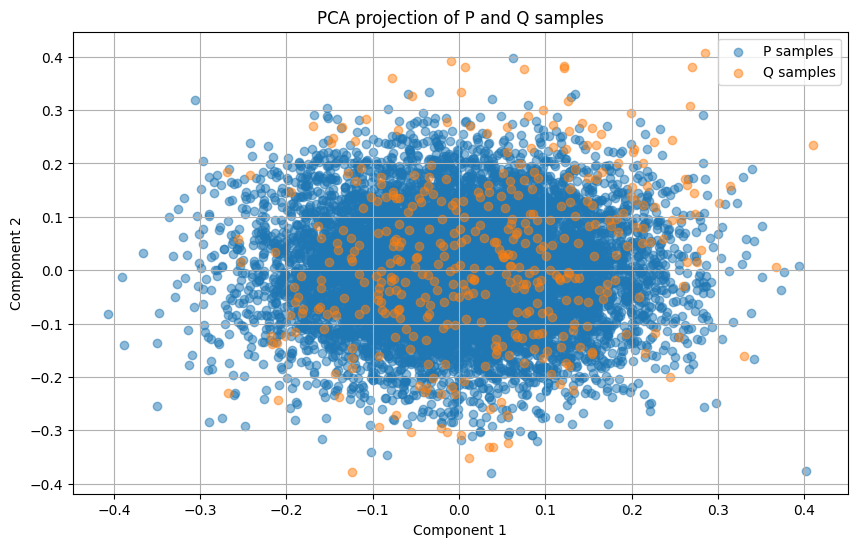

In [ ]:
vi_hmc_res = comparison_model_comparer.compare_sample_metrics_batch(test_batch["x"][:5], test_batch["y"][:5])

In [ ]:
print_wasserstein_distances(vi_hmc_res)

[0.4266628324985504, 0.3555838167667389, 0.22717873752117157, 0.3681538701057434, 0.2735488712787628]
0.33022562563419344
